# Libraries

In [5]:
library(extrafont)
library(magrittr)
library(dunn.test)
library(lme4)
library(Hmisc)
library(gamlss)
library(fitdistrplus)
library(ggrepel)
library(deSolve)
library(RColorBrewer)
library(gridExtra)
library(grid)
library(tidyverse)
library(boot)

Registering fonts with R
Loading required package: Matrix
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units

Loading required package: splines
Loading required package: gamlss.data
Loading required package: gamlss.dist
Loading required package: MASS
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:lme4’:

    lmList

Loading required package: parallel
 **********   GAMLSS Version 5.0-2  ********** 
For more on GAMLSS look at http://www.gamlss.org/
Type gamlssNews() to see new features/changes/bug fixes.


Attaching package: ‘gamlss’

The following object is masked from ‘package:lme4’:

    refit


Attaching package: ‘gridExtra’

The following object is masked from ‘package:Hmisc’:

    combine

Loading tidyverse: 

In [4]:
citation('deSolve')


To cite package 'deSolve' in publications use:

  Karline Soetaert, Thomas Petzoldt, R. Woodrow Setzer (2010). Solving
  Differential Equations in R: Package deSolve. Journal of Statistical
  Software, 33(9), 1--25. URL http://www.jstatsoft.org/v33/i09/ DOI
  10.18637/jss.v033.i09

A BibTeX entry for LaTeX users is

  @Article{,
    title = {Solving Differential Equations in R: Package deSolve},
    author = {Karline Soetaert and Thomas Petzoldt and R. Woodrow Setzer},
    journal = {Journal of Statistical Software},
    volume = {33},
    number = {9},
    pages = {1--25},
    year = {2010},
    coden = {JSSOBK},
    issn = {1548-7660},
    url = {http://www.jstatsoft.org/v33/i09},
    doi = {10.18637/jss.v033.i09},
    keywords = {ordinary differential equations, partial differential
    equations, differential algebraic equations, initial value problems,
    R, FORTRAN, C},
  }


# Plotting 

In [8]:
my.theme <- theme_classic() + 
  theme(panel.spacing.y = unit(0.1, "in"), 
        panel.spacing.x = unit(0.1, "in"), 
        text = element_text(family="Helvetica Neue", size = 9),
        line = element_line(size = 0.3),
        axis.line = element_line(size = 0.3), 
        strip.background  = element_rect(size = 0.7, fill = "grey95"),
        legend.key.height = unit(0.8, "line"),        
        legend.title = element_text(size = 8), 
        legend.text = element_text(size = 7))

Add a label to a plot for a multi-panel figure.

In [6]:
label.grob <- function(grob, label, x = 0.02, y = -0.3, size = 12) {
  arrangeGrob(grob, top = textGrob(label, x = x, y = y, hjust = 0, gp = gpar(fontsize = size)))
}

Lets plots share a legend. Code snippet from the ggplot2's Github [wiki](https://github.com/tidyverse/ggplot2/wiki/Share-a-legend-between-two-ggplot2-graphs).

In [7]:
grid_arrange_shared_legend <- function(..., ncol = length(list(...)), nrow = 1, position = c("bottom", "right")) {

  plots <- list(...)
  position <- match.arg(position)
  g <- ggplotGrob(plots[[1]] + theme(legend.position = position))$grobs
  legend <- g[[which(sapply(g, function(x) x$name) == "guide-box")]]
  lheight <- sum(legend$height)
  lwidth <- sum(legend$width)
  gl <- lapply(plots, function(x) x + theme(legend.position="none"))
  gl <- c(gl, ncol = ncol, nrow = nrow)

  combined <- switch(position,
                     "bottom" = arrangeGrob(do.call(arrangeGrob, gl),
                                            legend,
                                            ncol = 1,
                                            heights = unit.c(unit(1, "npc") - lheight, lheight)),
                     "right" = arrangeGrob(do.call(arrangeGrob, gl),
                                           legend,
                                           ncol = 2,
                                           widths = unit.c(unit(1, "npc") - lwidth, lwidth)))
  combined
#   grid.newpage()
#   grid.draw(combined)

#   # return gtable invisibly
#   invisible(combined)

}

# Load Data

## Lab strains

Loads a csv containing results from one trial

In [8]:
load.trial <- function(n) {
  filename <- paste("../data/reformatted/lab-strain-invasion/trial-", n, ".csv", sep='')
  col_types <- cols(
    Strain = col_character(),
    Age    = col_character(),
    RBC    = col_integer(),
    One    = col_integer(),
    Two    = col_integer(),
    Three  = col_integer(),
    Four   = col_integer(),
    Five   = col_integer()
  )
  trial <- read_csv(filename, col_types=col_types)
  trial$Trial <- n
  return(trial)
}

Load all trials, merge them into one dataframe, and remove NA. Each trial, parasite strain, RBC age combination should have three entries, since the experiments were done in triplicate. 

In [9]:
invasion <- 22:29 %>%
  map(load.trial) %>% 
  reduce(full_join, by=c("Strain", "Age", "RBC", "One", "Two", "Three", "Four", "Five", "Trial")) %>%
  mutate(
    Strain    = parse_factor(Strain, levels = c("Dd2", "Dd2NM", "C2", "3D7", "FCR3", "HB3", "EFcyc2")),
    Trial     = parse_factor(Trial, levels = NULL),
    Age       = parse_factor(Age, levels = c("Positive", "Very Young", "Young", "Medium", "Old")), # set the order (good for plotting later)
    Age.Short = recode(Age, Positive = "P", "Very Young" = "VY", Young = "Y", Medium = "M", Old = "O")
  ) %>% 
  replace_na(list(RBC = 0, One = 0, Two = 0, Three = 0, Four = 0, Five = 0)) %>%
  mutate(
    Strain = recode(Strain, "Dd2NM" = "Dd2Nm")
  )
head(invasion)

Strain,Age,RBC,One,Two,Three,Four,Five,Trial,Age.Short
Dd2,Positive,261,33,10,1,0,1,22,P
Dd2,Positive,269,21,10,1,0,0,22,P
Dd2,Positive,259,21,8,0,0,0,22,P
Dd2,Very Young,259,18,7,2,0,0,22,VY
Dd2,Very Young,253,26,8,3,1,0,22,VY
Dd2,Very Young,254,25,11,2,0,0,22,VY


There are two replicates which have no data...

In [10]:
filter(invasion, RBC == 0)

Strain,Age,RBC,One,Two,Three,Four,Five,Trial,Age.Short
Dd2,Very Young,0,0,0,0,0,0,25,VY
Dd2,Very Young,0,0,0,0,0,0,25,VY


Remove them

In [11]:
cat(paste('rows before:', nrow(invasion), "\n"))
invasion %<>%
  filter(RBC != 0)
cat(paste('rows after:', nrow(invasion)))

rows before: 615 
rows after: 613

Check how many triplicates are available for each strain / age

In [12]:
invasion %>%
  group_by(Strain, Age) %>%
  count() %>%
  arrange(desc(n))

Strain,Age,n
Dd2,Positive,24
Dd2,Young,24
Dd2,Medium,24
Dd2,Old,24
3D7,Positive,24
3D7,Very Young,24
3D7,Young,24
3D7,Medium,24
3D7,Old,24
Dd2,Very Young,22


EFcyc2 only has 9 triplicates (3 trials), so remove that strain from analysis

In [13]:
cat(paste('rows before:', nrow(invasion), "\n"))
invasion %<>%
  filter(Strain != "EFcyc2")
cat(paste('rows after:', nrow(invasion)))

rows before: 613 
rows after: 568

## Field isolates

In [14]:
field.filename <- "../data/reformatted/senegal-strains-invasion/senegal-strains.csv"
field.data <- read_csv(field.filename, col_types = cols(
    Strain    = col_character(),
    Age       = col_character(),
    One       = col_integer(),
    Two       = col_integer(),
    Three     = col_integer(),
    Four      = col_integer(),
    Five      = col_integer(),
    Parasites = col_integer(),
    RBC       = col_integer()
  )) %>%
  fill(Strain, Age) %>%
  rename(Age.Short = Age) %>%
  dplyr::select(-Parasites) %>%
  mutate(
    Age.Short = parse_factor(Age.Short, levels = c("P", "VY", "Y", "M", "O")),
    Age = recode(Age.Short, P = "Positive", VY = "Very Young", Y = "Young", M = "Medium", O = "Old")
  )

Warning message:
“Assigning non-quosure objects to quosure lists is deprecated as of rlang 0.3.0.
Please coerce to a bare list beforehand with `as.list()`
This warning is displayed once per session.”Warning message:
“Quosure lists can't be concatenated with objects other than quosures as of rlang 0.3.0.
Please call `as.list()` on the quosure list first.
This warning is displayed once per session.”

In the original data, the `Zero = 9 * RBC - (Two + ... + Five)`. No idea why `One` (assuming this is singly-infected cells) was not also subtracted from the total number of cells (`9 * RBC`).

In [15]:
field.data %<>%
  mutate(
    infected    = One + Two + Three + Four + Five,
    total       = RBC * 9,
    zero        = total - infected,
    parasitemia = infected / total
  )

Average over triplicates

In [16]:
field.data %<>%
  group_by(Strain, Age, Age.Short) %>%
  summarise_each(funs(mean))

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”

In [17]:
head(field.data, 10)

Strain,Age,Age.Short,One,Two,Three,Four,Five,RBC,infected,total,zero,parasitemia
P102,Very Young,VY,89.66667,29.000000,7.6666667,0.0000000,0,767.3333,126.33333,6906,6779.667,0.018276447
P102,Young,Y,52.66667,17.333333,4.3333333,0.0000000,0,776.6667,74.33333,6990,6915.667,0.010635709
P102,Medium,M,31.00000,8.666667,1.3333333,0.0000000,0,757.3333,41.00000,6816,6775.000,0.006015372
P102,Old,O,13.33333,5.000000,0.3333333,0.0000000,0,754.3333,18.66667,6789,6770.333,0.002747627
P106,Very Young,VY,87.00000,46.666667,21.3333333,0.6666667,0,759.6667,155.66667,6837,6681.333,0.022765762
P106,Young,Y,88.33333,34.666667,10.3333333,0.6666667,0,756.0000,134.00000,6804,6670.000,0.019693557
P106,Medium,M,45.66667,14.333333,5.0000000,0.0000000,0,794.3333,65.00000,7149,7084.000,0.009117145
P106,Old,O,13.00000,3.666667,0.3333333,0.0000000,0,757.0000,17.00000,6813,6796.000,0.002497486
P107,Very Young,VY,99.66667,41.666667,20.0000000,0.0000000,0,757.3333,161.33333,6816,6654.667,0.023674032
P107,Young,Y,53.00000,30.333333,11.0000000,0.0000000,0,754.3333,94.33333,6789,6694.667,0.013896343


# Parasitemia

Calculate parasitemias per triplicate, then average. Derived columns:
- ```infected```: The sum of singly- and multiply-infected RBCs
- ```total```: The total is estimated from 1/9th of the microscope viewing area.
- ```parasitemia```: Infected / Total

In [18]:
invasion %<>%
  mutate(
    infected    = One + Two + Three + Four + Five,
    total       = 9 * RBC,
    zero        = total - infected,
    parasitemia = infected / total
  ) %>%
  group_by(Strain, Age, Age.Short, Trial) %>%
  summarise_each(funs(mean))

invasion %>% head(5)

Strain,Age,Age.Short,Trial,RBC,One,Two,Three,Four,Five,infected,total,zero,parasitemia
Dd2,Positive,P,22,263,25.00000,9.333333,0.6666667,0.0000000,0.3333333,35.33333,2367,2331.667,0.01493859
Dd2,Positive,P,23,259,27.66667,7.666667,2.0000000,0.0000000,0.3333333,37.66667,2331,2293.333,0.01614356
Dd2,Positive,P,24,276,23.33333,6.333333,3.3333333,1.0000000,0.0000000,34.00000,2484,2450.000,0.01374563
Dd2,Positive,P,25,272,42.00000,14.333333,2.6666667,1.3333333,0.0000000,60.33333,2448,2387.667,0.02469089
Dd2,Positive,P,26,276,24.66667,6.333333,1.6666667,0.3333333,0.3333333,33.33333,2484,2450.667,0.01346661


Normalize parasitemia (averaged over triplicates) by the positive controls

In [19]:
invasion %<>%
  group_by(Strain, Trial) %>%
  mutate(
    normalized.parasitemia = parasitemia / parasitemia[Age=="Positive"]
  ) %>%
  ungroup()
head(invasion)

Strain,Age,Age.Short,Trial,RBC,One,Two,Three,Four,Five,infected,total,zero,parasitemia,normalized.parasitemia
Dd2,Positive,P,22,263,25.00000,9.333333,0.6666667,0.0000000,0.3333333,35.33333,2367,2331.667,0.01493859,1
Dd2,Positive,P,23,259,27.66667,7.666667,2.0000000,0.0000000,0.3333333,37.66667,2331,2293.333,0.01614356,1
Dd2,Positive,P,24,276,23.33333,6.333333,3.3333333,1.0000000,0.0000000,34.00000,2484,2450.000,0.01374563,1
Dd2,Positive,P,25,272,42.00000,14.333333,2.6666667,1.3333333,0.0000000,60.33333,2448,2387.667,0.02469089,1
Dd2,Positive,P,26,276,24.66667,6.333333,1.6666667,0.3333333,0.3333333,33.33333,2484,2450.667,0.01346661,1
Dd2,Positive,P,27,271,27.00000,9.333333,2.6666667,0.3333333,0.0000000,39.33333,2439,2399.667,0.01623571,1


## Effect of age on parasitemia

Plot, see if there's any within-strain heterogeneity by age group

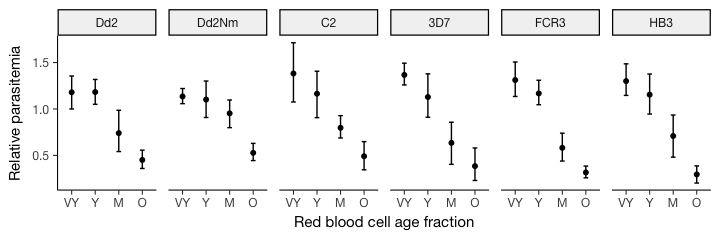

In [20]:
options(repr.plot.width=6, repr.plot.height=2)

ggplot(filter(invasion, Age.Short != "P"), aes(x=Age.Short, y=normalized.parasitemia)) + 
  stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0.2, size = 0.4) + 
  stat_summary(fun.y = mean, geom = "point", size = 1) + 
  facet_wrap(~ Strain, nrow=1) +
  labs(y="Relative parasitemia", x = "Red blood cell age fraction") + 
  my.theme +
  theme(axis.text.x=element_text(hjust=0.5, vjust=1))

ggsave('../figures/parasitemia-vs-age-by-strain.pdf', width = 6, height = 2)

Check using Kruskal-Wallis

In [21]:
strains = as.character(unique(invasion$Strain))
within.strain.kw <- function(strain, variable, df) {
  kruskal.test(get(variable) ~ Age, data=filter(df, Strain==strain, Age != "Positive"))
}
cat(paste("Bonferroni-adjusted significance level:", format(round(0.05 / length(strains), 5))))
sapply(strains, within.strain.kw, variable="normalized.parasitemia", df=invasion)

Bonferroni-adjusted significance level: 0.00833

,Dd2,Dd2Nm,C2,3D7,FCR3,HB3
statistic,19.2017,11.89143,12.92,20.78693,18.69333,17.10667
parameter,3,3,3,3,3,3
p.value,0.0002483598,0.007764487,0.004812843,0.0001165653,0.0003163596,0.0006719243
method,Kruskal-Wallis rank sum test,Kruskal-Wallis rank sum test,Kruskal-Wallis rank sum test,Kruskal-Wallis rank sum test,Kruskal-Wallis rank sum test,Kruskal-Wallis rank sum test
data.name,get(variable) by Age,get(variable) by Age,get(variable) by Age,get(variable) by Age,get(variable) by Age,get(variable) by Age


Try a parametric test

In [22]:
within.strain.anova <- function(strain, variable, df) {
  oneway.test(get(variable) ~ Age, data=filter(df, Strain==strain, Age != "Positive"))
}
cat(paste("Bonferroni-adjusted significance level:", format(round(0.05 / length(strains), 5))))
sapply(strains, within.strain.anova, variable="normalized.parasitemia", df=invasion)

Bonferroni-adjusted significance level: 0.00833

,Dd2,Dd2Nm,C2,3D7,FCR3,HB3
statistic,26.40213,19.8648,8.554848,25.04838,48.14996,30.83169
parameter,"3.00000, 14.97517","3.000000, 8.554251","3.000000, 8.462648","3.00000, 14.96516","3.0000, 10.0974","3.00000, 10.26505"
p.value,3.148281e-06,0.0003351125,0.006168745,4.383155e-06,2.755365e-06,1.921136e-05
method,One-way analysis of means (not assuming equal variances),One-way analysis of means (not assuming equal variances),One-way analysis of means (not assuming equal variances),One-way analysis of means (not assuming equal variances),One-way analysis of means (not assuming equal variances),One-way analysis of means (not assuming equal variances)
data.name,get(variable) and Age,get(variable) and Age,get(variable) and Age,get(variable) and Age,get(variable) and Age,get(variable) and Age


Follow-up with pairwise comparisons

In [23]:
within.strain.dunn <- function(strain, variable, df) {
  df = filter(df, Strain == strain, Age != "Positive")
  dunn.test(df[[variable]], df[['Age']], method='bonferroni')
}

In [24]:
kw <- within.strain.dunn('Dd2', 'normalized.parasitemia', invasion)

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 19.2017, df = 3, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |     Medium        Old   Very You
---------+---------------------------------
     Old |   1.519055
         |     0.3862
         |
Very You |  -2.078706  -3.597762
         |     0.1129     0.0010
         |
   Young |  -2.211957  -3.731012  -0.133250
         |     0.0809     0.0006     1.0000



In [25]:
kw

$chi2
[1] 19.2017

$Z
[1]  1.5190551 -2.0787070 -3.5977621 -2.2119574 -3.7310125 -0.1332504

$P
[1] 6.437431e-02 1.882215e-02 1.604835e-04 1.348480e-02 9.535587e-05
[6] 4.469977e-01

$P.adjusted
[1] 0.3862458787 0.1129328719 0.0009629010 0.0809088190 0.0005721352
[6] 1.0000000000

$comparisons
[1] "Medium - Old"        "Medium - Very Young" "Old - Very Young"   
[4] "Medium - Young"      "Old - Young"         "Very Young - Young"

TODO? annotate parasitemia vs age plots with significance markers

## Effect of strain on parasitemia

Plot parasitemia for each RBC age group. We can see the variability between trials.

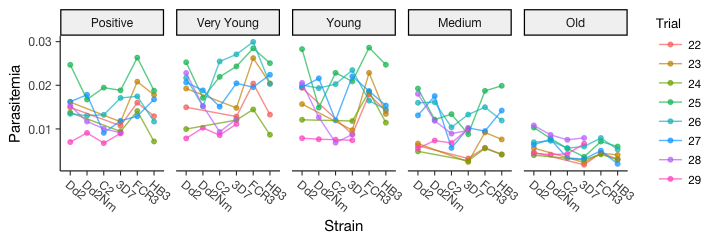

In [26]:
options(repr.plot.width=6, repr.plot.height=2)

ggplot(invasion, aes(x=Strain, y=parasitemia)) + 
  #geom_boxplot(coef=10) + # hack so to show range, i.e. allow whiskers to go as far as +/- 10 * IQR 
  geom_point(aes(color=Trial, group=Trial), alpha=0.7, size = 1) +
  geom_line(aes(color=Trial, group=Trial), alpha=0.7, size = 0.4) +
  facet_wrap(~Age, nrow=1) +
  labs(y="Parasitemia") + 
  my.theme +
  theme(axis.text.x=element_text(angle=-40, hjust=0, vjust=1))

ggsave('../figures/parasitemia-vs-strain-by-age-show-all.pdf', width = 6, height = 2)

Plot normalized parasitemia to control for trial effects. For the paper, only show the mean and bootstrapped CI for each strain.

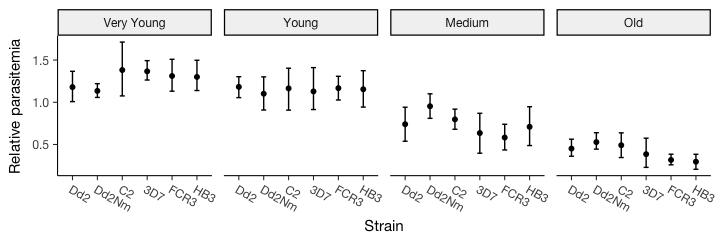

In [27]:
options(repr.plot.width = 6, repr.plot.height = 2)

fig2a <- ggplot(filter(invasion, Age != "Positive"), aes(x=Strain, y=normalized.parasitemia)) + 
  stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0.2, size = 0.4) + 
  stat_summary(fun.y = mean, geom = "point", size = 1) + 
  #geom_boxplot(coef = 10, color = 'grey40', alpha = 0.3) +
  #geom_point(alpha=0.8) +
  #geom_line(aes(color=Trial, group=Trial), alpha=0.4) +
  facet_wrap(~ Age, nrow = 1) +
  labs(y="Relative parasitemia") + 
  my.theme +
  theme(axis.text.x=element_text(angle=-30, hjust=0, vjust=1))

fig2a

ggsave('../figures/parasitemia-vs-strain-by-age-summary.pdf', width = 6, height = 2)

Test for strain heterogeneity within age groups. Kruskal-Wallis is non-parametric. Does not assume normality, probably at cost of power. But also assumes equal variance.

In [28]:
age_groups = c('Very Young', 'Young', 'Medium', 'Old')
within.age.kw <- function(age, variable, df) {
  kruskal.test(get(variable) ~ Strain, data=filter(df, Age == age))
}
cat(paste("Bonferroni-adjusted significance level:", format(round(0.05 / length(age_groups), 5))))
sapply(age_groups, within.age.kw, variable='normalized.parasitemia', df=invasion)

Bonferroni-adjusted significance level: 0.0125

,Very Young,Young,Medium,Old
statistic,5.58664,1.246694,4.865182,10.24258
parameter,5,5,5,5
p.value,0.348539,0.9403201,0.4325543,0.06864655
method,Kruskal-Wallis rank sum test,Kruskal-Wallis rank sum test,Kruskal-Wallis rank sum test,Kruskal-Wallis rank sum test
data.name,get(variable) by Strain,get(variable) by Strain,get(variable) by Strain,get(variable) by Strain


Try again using a parametric test. ```oneway.test``` defaults to unequal variances (generalization of two-sample Welch test, see more by running ```?oneway.test```)

In [29]:
within.age.anova <- function(age, variable, df) {
  oneway.test(get(variable) ~ Strain, data=filter(df, Age==age))
}
cat(paste("Bonferroni-adjusted significance level:", format(round(0.05 / length(age_groups), 5))))
sapply(age_groups, within.age.anova, variable="normalized.parasitemia", df=invasion)

Bonferroni-adjusted significance level: 0.0125

,Very Young,Young,Medium,Old
statistic,1.68002,0.07181328,1.750373,2.682629
parameter,"5.0000, 13.9099","5.00000, 13.67503","5.00000, 14.49795","5.000, 13.951"
p.value,0.2044024,0.9955544,0.1858999,0.066798
method,One-way analysis of means (not assuming equal variances),One-way analysis of means (not assuming equal variances),One-way analysis of means (not assuming equal variances),One-way analysis of means (not assuming equal variances)
data.name,get(variable) and Strain,get(variable) and Strain,get(variable) and Strain,get(variable) and Strain


# Models

## Selectivity Index

Add  derived columns
- ```lambda```: Average number of merozoites per RBC
- ```mi.expected```: Expected number of multiply-infected RBCs based on Poisson with mean.multiplicity
- ```mi.observed```: Observed number of multiply-infected RBCs
- ```selectivity.index```: Observed divided by expected number of multiply-infected RBCs

```lambda``` is the MLE for the Poisson model. Also calculate and look at the selectivity index, which uses the Poisson distribution as the null model of multiplicity of infection.

In [30]:
invasion %<>% 
  mutate(
    lambda            = (1 * One + 2 * Two + 3 * Three + 4 * Four + 5 * Five) / total,
    mi.expected       = (1 - (1 + lambda) * exp(-lambda)) * total,
    mi.observed       = infected - One,
    selectivity.index = mi.observed / mi.expected
  )
head(invasion)

Strain,Age,Age.Short,Trial,RBC,One,Two,Three,Four,Five,infected,total,zero,parasitemia,normalized.parasitemia,lambda,mi.expected,mi.observed,selectivity.index
Dd2,Positive,P,22,263,25.00000,9.333333,0.6666667,0.0000000,0.3333333,35.33333,2367,2331.667,0.01493859,1,0.01999718,0.4670044,10.333333,22.12684
Dd2,Positive,P,23,259,27.66667,7.666667,2.0000000,0.0000000,0.3333333,37.66667,2331,2293.333,0.01614356,1,0.02173602,0.5427313,10.000000,18.42532
Dd2,Positive,P,24,276,23.33333,6.333333,3.3333333,1.0000000,0.0000000,34.00000,2484,2450.000,0.01374563,1,0.02012882,0.4965185,10.666667,21.48292
Dd2,Positive,P,25,272,42.00000,14.333333,2.6666667,1.3333333,0.0000000,60.33333,2448,2387.667,0.02469089,1,0.03431373,1.4086287,18.333333,13.01502
Dd2,Positive,P,26,276,24.66667,6.333333,1.6666667,0.3333333,0.3333333,33.33333,2484,2450.667,0.01346661,1,0.01825013,0.4086710,8.666667,21.20695
Dd2,Positive,P,27,271,27.00000,9.333333,2.6666667,0.3333333,0.0000000,39.33333,2439,2399.667,0.01623571,1,0.02255023,0.6108868,12.333333,20.18923


Normalize to control for trial effects. Not clear what is the best way to do this. Divide? Subtract? Logscale?

In [31]:
invasion %<>%
  group_by(Strain, Trial) %>%
  mutate(
    normalized.si = selectivity.index / selectivity.index[Age=="Positive"]
  ) %>%
  ungroup()
head(invasion)

Strain,Age,Age.Short,Trial,RBC,One,Two,Three,Four,Five,infected,total,zero,parasitemia,normalized.parasitemia,lambda,mi.expected,mi.observed,selectivity.index,normalized.si
Dd2,Positive,P,22,263,25.00000,9.333333,0.6666667,0.0000000,0.3333333,35.33333,2367,2331.667,0.01493859,1,0.01999718,0.4670044,10.333333,22.12684,1
Dd2,Positive,P,23,259,27.66667,7.666667,2.0000000,0.0000000,0.3333333,37.66667,2331,2293.333,0.01614356,1,0.02173602,0.5427313,10.000000,18.42532,1
Dd2,Positive,P,24,276,23.33333,6.333333,3.3333333,1.0000000,0.0000000,34.00000,2484,2450.000,0.01374563,1,0.02012882,0.4965185,10.666667,21.48292,1
Dd2,Positive,P,25,272,42.00000,14.333333,2.6666667,1.3333333,0.0000000,60.33333,2448,2387.667,0.02469089,1,0.03431373,1.4086287,18.333333,13.01502,1
Dd2,Positive,P,26,276,24.66667,6.333333,1.6666667,0.3333333,0.3333333,33.33333,2484,2450.667,0.01346661,1,0.01825013,0.4086710,8.666667,21.20695,1
Dd2,Positive,P,27,271,27.00000,9.333333,2.6666667,0.3333333,0.0000000,39.33333,2439,2399.667,0.01623571,1,0.02255023,0.6108868,12.333333,20.18923,1


Plot selectivity index

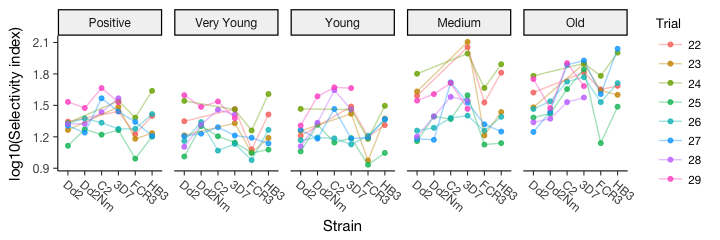

In [32]:
options(repr.plot.width=6, repr.plot.height=2)

ggplot(invasion, aes(x=Strain, y=log10(selectivity.index))) + 
  #geom_boxplot(coef=10, color='grey40') +
  geom_point(aes(color=Trial), alpha=0.8, size = 1) +
  geom_line(aes(color=Trial, group=Trial), alpha=0.4, size = 0.4) +
  facet_wrap(~Age, nrow=1) +
  labs(y="log10(Selectivity index)") + 
  my.theme +
  theme(axis.text.x=element_text(angle=-40, hjust=0, vjust=1))

ggsave('../figures/s-index-vs-strain-by-age-show-all.pdf', width = 6, height = 2)

Plot normalized selectivity index. What a mess.

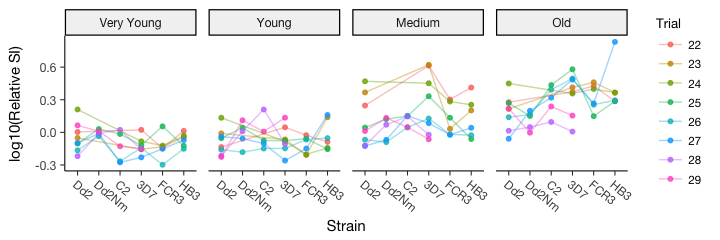

In [33]:
options(repr.plot.width = 6, repr.plot.height = 2)

ggplot(filter(invasion, Age != "Positive"), aes(x=Strain, y=log10(normalized.si))) + 
  #geom_boxplot(coef=10, color='grey40') +
  geom_point(aes(color=Trial), alpha=0.8, size = 1) +
  geom_line(aes(color=Trial, group=Trial), alpha=0.4, size = 0.4) +
  facet_wrap(~Age, nrow=1) +
  labs(y="log10(Relative SI)") + 
  my.theme +
  theme(axis.text.x=element_text(angle=-40, hjust=0, vjust=1))

ggsave('../figures/norm-s-index-parasitemia-vs-strain-by-age-show-all.pdf', width = 6, height = 2)

## Poisson Models

We collect data on $n$ RBCs. Let $A_i$ be an indicator random variable for whether the $i$-th RBC was accessible to merozoite invasion. Let $A_i$ = 1 with probability $f$. $n$ is unknown, but estimated based on a 1/9th sample. But we will assume it is known for now. Let $Y_i$ be the number of parasites in an RBC after a re-invasion cycle. We assume that $Y_i\,|\,A_i = 0$ is always 0 (i.e., inaccessible RBCs are never infected), and $Y_i\,|\,A_i=1$ follows a Poisson distribution with mean $\lambda$. 

Suppose we observe a random sample $Y_1, \dots, Y_n$. Let $S_k = \sum_i I(Y_i = k)$, i.e. the number of RBCs infected with exactly k parasites. The likelihood function is 

$L(f, \lambda) = [(1 - f) + fe^{-\lambda}]^{S_0}\prod_{k=1}^\infty [f\lambda^k e^{-\lambda}/k!]^{S_k}$,

and the loglikelihood is

$l(f, \lambda) = S_0[\log(1 - f + fe^{-\lambda})] + \sum_{k=1}^\infty S_k[\log(f) + k\log(\lambda) - \log(k!) - \lambda]$.

Let $T = \sum_{k=1}^\infty S_k$. We can simplify the loglikelihood:

$l(f, \lambda) = S_0[\log(1 - f + fe^{-\lambda})] + T[\log(f) - \lambda] + \sum_{k=1}^\infty S_k[k\log(\lambda) - \log(k!)]$.

See http://en.wikipedia.org/wiki/Zero-inflated_model#Zero-inflated_Poisson

Define functions to fit the non-zero-inflated Poisson model and the zero-inflated Poisson model to each observation / row. ```fitdist``` also computes the log likelihood, which is nice.

In [34]:
fit.pois <- function(row) {
  # multiply by 3 to recover integer counts (remember we had averaged over triplicates)
  # will not affect ML point estimate, but scales the logllh by a factor of 3
  counts <- 3 * c(row$zero, row$One, row$Two, row$Three, row$Four, row$Five)
    
  fit <- safely(fitdist)(rep(0:(length(counts) - 1), counts), 'pois')
  success <- !is.null(fit$result) 
  data.frame(
    pois.success   = success,
    pois.lambda    = if (success) fit$result$estimate[['lambda']] else -1,
    pois.llh       = if (success) fit$result$loglik / 3           else -1
  )
}

In [35]:
# mu is Poisson mean, sigma is prob of structural zero
fit.zip <- function(row, mu, sigma) {
  # multiply by 3 to recover integer counts (remember we had averaged over triplicates)
  # will not affect ML point estimate, but scales the logllh by a factor of 3
  counts <- 3 * c(row$zero, row$One, row$Two, row$Three, row$Four, row$Five)
  
  fit <- safely(fitdist)(rep(0:(length(counts) - 1), counts), 'ZIP', 
                          start = list(mu = mu, sigma = sigma), 
                          lower = c(1e-8, 1e-8), upper = c(Inf, 1 - 1e-8), optim.method = "Nelder-Mead", discrete = TRUE)
  success = !is.null(fit$result)
  data.frame(
    zip.success = success,
    zip.lambda  = if (success) fit$result$estimate[['mu']]    else -1,
    zip.frac    = if (success) fit$result$estimate[['sigma']] else -1,
    zip.llh     = if (success) fit$result$loglik / 3          else -1
  )
}

Fit vanilla model and check for any rows that were not fit successfully

In [36]:
invasion %<>%
  by_row(..f = fit.pois,  .collate = 'cols') %>% # column names have "1" appended
  subset(select = which(!duplicated(colnames(.), fromLast = TRUE)))  # if we fit more than once, column names will be duplicated. keep only the more recent set of columns

In [37]:
invasion %>% filter(!pois.success1)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”

Strain,Age,Age.Short,Trial,RBC,One,Two,Three,Four,Five,⋯,parasitemia,normalized.parasitemia,lambda,mi.expected,mi.observed,selectivity.index,normalized.si,pois.success1,pois.lambda1,pois.llh1


In [38]:
invasion %>% head()

Strain,Age,Age.Short,Trial,RBC,One,Two,Three,Four,Five,⋯,parasitemia,normalized.parasitemia,lambda,mi.expected,mi.observed,selectivity.index,normalized.si,pois.success1,pois.lambda1,pois.llh1
Dd2,Positive,P,22,263,25.00000,9.333333,0.6666667,0.0000000,0.3333333,⋯,0.01493859,1,0.01999718,0.4670044,10.333333,22.12684,1,TRUE,0.01999718,-241.7688
Dd2,Positive,P,23,259,27.66667,7.666667,2.0000000,0.0000000,0.3333333,⋯,0.01614356,1,0.02173602,0.5427313,10.000000,18.42532,1,TRUE,0.02173602,-255.1519
Dd2,Positive,P,24,276,23.33333,6.333333,3.3333333,1.0000000,0.0000000,⋯,0.01374563,1,0.02012882,0.4965185,10.666667,21.48292,1,TRUE,0.02012882,-258.8206
Dd2,Positive,P,25,272,42.00000,14.333333,2.6666667,1.3333333,0.0000000,⋯,0.02469089,1,0.03431373,1.4086287,18.333333,13.01502,1,TRUE,0.03431373,-386.2162
Dd2,Positive,P,26,276,24.66667,6.333333,1.6666667,0.3333333,0.3333333,⋯,0.01346661,1,0.01825013,0.4086710,8.666667,21.20695,1,TRUE,0.01825013,-236.8605
Dd2,Positive,P,27,271,27.00000,9.333333,2.6666667,0.3333333,0.0000000,⋯,0.01623571,1,0.02255023,0.6108868,12.333333,20.18923,1,TRUE,0.02255023,-275.8673


Fit ZIP and check for rows that were not fit successfully

In [39]:
invasion %<>%
  by_row(..f = fit.zip, .collate = 'cols', mu = 0.005, sigma = 1e-5) %>%
  subset(select = which(!duplicated(colnames(.), fromLast = TRUE)))

In [40]:
invasion %>% filter(!zip.success1)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”

Strain,Age,Age.Short,Trial,RBC,One,Two,Three,Four,Five,⋯,mi.observed,selectivity.index,normalized.si,pois.success1,pois.lambda1,pois.llh1,zip.success1,zip.lambda1,zip.frac1,zip.llh1


Take a look at the new columns

In [41]:
invasion %>% sample_n(10)

Strain,Age,Age.Short,Trial,RBC,One,Two,Three,Four,Five,⋯,mi.observed,selectivity.index,normalized.si,pois.success1,pois.lambda1,pois.llh1,zip.success1,zip.lambda1,zip.frac1,zip.llh1
3D7,Medium,M,25,268.3333,12.33333,6.333333,2.3333333,0.3333333,0.0000000,⋯,9.000000,39.48445,2.1489992,TRUE,0.013802623,-185.7266,TRUE,0.9706202,0.9857812,-143.3002
Dd2Nm,Young,Y,29,267.0000,12.66667,3.333333,2.0000000,0.3333333,0.0000000,⋯,5.666667,38.58206,1.2918405,TRUE,0.011097240,-153.6483,TRUE,0.8028008,0.9861794,-124.2845
C2,Very Young,VY,26,256.0000,42.66667,11.000000,4.3333333,0.6666667,0.0000000,⋯,16.000000,11.69287,0.5416836,TRUE,0.034866898,-367.4571,TRUE,0.6651312,0.9475853,-320.1817
Dd2,Positive,P,29,316.6667,16.00000,2.333333,1.0000000,0.0000000,0.0000000,⋯,3.333333,34.11009,1.0000000,TRUE,0.008304094,-140.4629,TRUE,0.4189098,0.9801767,-127.1738
HB3,Very Young,VY,27,256.3333,37.00000,10.333333,4.0000000,0.3333333,0.0000000,⋯,14.666667,13.70223,0.8486886,TRUE,0.030775899,-333.5416,TRUE,0.6732963,0.9542817,-288.7621
C2,Very Young,VY,28,262.3333,16.33333,4.000000,0.6666667,0.6666667,0.3333333,⋯,5.666667,28.69982,1.0531451,TRUE,0.012988847,-171.5540,TRUE,0.7054789,0.9815939,-143.6846
Dd2Nm,Young,Y,26,256.3333,29.33333,9.666667,3.3333333,2.3333333,0.0000000,⋯,15.333333,15.60342,0.6573722,TRUE,0.029475509,-327.7337,TRUE,0.9089990,0.9675772,-264.5610
Dd2Nm,Old,O,27,267.0000,15.66667,2.000000,0.6666667,0.0000000,0.0000000,⋯,2.666667,27.46489,1.5794495,TRUE,0.009016507,-126.2693,TRUE,0.3441819,0.9737982,-117.0335
Dd2,Very Young,VY,29,255.6667,12.66667,4.333333,0.6666667,0.0000000,0.3333333,⋯,5.333333,39.55575,1.1596495,TRUE,0.010864841,-143.8496,TRUE,0.6976364,0.9844213,-120.1992
HB3,Medium,M,25,292.6667,41.00000,8.666667,2.6666667,0.0000000,0.0000000,⋯,11.333333,13.79823,0.8680906,TRUE,0.025183498,-321.3292,TRUE,0.4941961,0.9490536,-291.0005


Rename columns to remove the trailing 1

In [42]:
names(invasion) %<>% 
  map(~ if (endsWith(., "1")) substr(., 1, nchar(.) - 1) else .)

Warning message:
“Must use a character vector as names.
This warning is displayed once per session.”

## Compare model fits

### Likelihood ratio tests

In [43]:
invasion %<>%
  mutate(
    lrt.chisq  = -2 * (pois.llh - zip.llh),
    lrt.p      = (1 - pchisq(lrt.chisq, 1)), 
    lrt.p.clip = pmax(lrt.p, min(lrt.p[lrt.p > 0] / 10)) # some p-values are 0. set them to the lowest non-zero p-value divided by 10 (for plotting purposes)
  )

In [44]:
sig.level <- 0.05 / nrow(invasion) # Bonferroni corrected
invasion %<>% 
  mutate(
    lrt.sig = lrt.p < sig.level
  )

In [45]:
cat(paste0("ZIP significantly better fit than Poisson for ", 
           invasion %>% filter(lrt.sig == TRUE) %>% nrow(), 
           " out of ", 
           invasion %>% nrow(),
           " strain/age/trial combinations."))

ZIP significantly better fit than Poisson for 169 out of 190 strain/age/trial combinations.

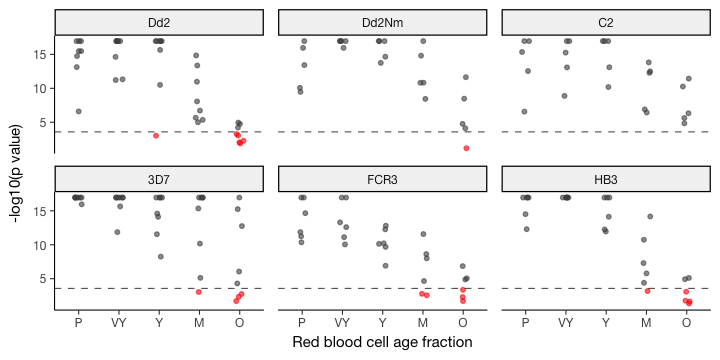

In [46]:
options(repr.plot.width = 6, repr.plot.height = 3)

ggplot(invasion, aes(x = Age.Short, y = -log10(lrt.p.clip))) + 
  geom_jitter(aes(color = lrt.sig), size = 1, alpha = 0.6, width = 0.1) + 
  geom_hline(yintercept = -log10(sig.level), size = 0.22, color = 'black', linetype = "dashed") + 
  facet_wrap(~ Strain, nrow = 2) + 
  labs(x = "Red blood cell age fraction", y = "-log10(p value)") + 
  scale_colour_manual(values = c('red', 'grey30')) +
  my.theme +
  theme(panel.spacing.x = unit(0.3, 'cm'), legend.position="none")

ggsave("../figures/poisson-model-comparison-pvalues.pdf", width = 6, height = 3)

### Plot predicted values

In [47]:
predicted.long <- invasion %>% 
  #filter(Strain == "3D7", Age == "Very Young", Trial == 22) %>% 
  gather("MOI", "count", c(zero, One, Two, Three, Four, Five)) %>% 
  mutate(
    MOI = recode(MOI, zero = 0, One = 1, Two = 2, Three = 3, Four = 4, Five = 5),
    pois.count = total * dpois(MOI, pois.lambda),
    zip.count =  total * dZIP(MOI, zip.lambda, zip.frac)
  ) %>%
  dplyr::select(Age.Short, Strain, Trial, MOI, count, pois.count, zip.count)

options(scipen = 50, digits = 4)
sample_n(predicted.long, 5)

Age.Short,Strain,Trial,MOI,count,pois.count,zip.count
VY,3D7,26,5,0.000,0.00000185873,0.160519
Y,FCR3,24,0,2252.333,2242.93304596575,2252.341143
O,HB3,25,0,2335.000,2333.05436775622,2335.001819
O,Dd2,22,4,0.000,0.00000007096,0.005164
Y,FCR3,26,3,1.333,0.00319387614,0.980595


In [48]:
strains

[1] "Dd2"   "Dd2Nm" "C2"    "3D7"   "FCR3"  "HB3"

In [49]:
options(repr.plot.width=8, repr.plot.height=6, scipen=50, digits = 3)

plots <- strains %>% 
  map (function(strain) {
    obs <- predicted.long %>%
      filter(Strain == strain) %>%
      gather("type", "count", c(count, pois.count, zip.count)) %>%
      mutate(
        type = recode(type, 
                      count = 'observed', 
                      pois.count = 'predicted (Poisson)', 
                      zip.count = 'predicted (ZIP)')
      ) %>%
      dplyr::select(Age.Short, Strain, Trial, MOI, count, type)

    ggplot(obs, aes(x = MOI, y = count, color = type, group = type, shape = type)) +
      geom_line(alpha = 0.6, size = 0.4) + 
      geom_point(alpha = 0.6, size = 1) + 
      #scale_y_continuous(limits = c(0, NA), expand = c(0, 0)) +
      scale_x_continuous(breaks = seq(0, 5, by = 1), name = "Multiplicity of infection") + 
      scale_y_log10(limits = c(1e-3, NA), name = 'Frequency') + 
      scale_colour_brewer(palette = "Dark2", name = '') + 
      facet_grid(Trial ~ Age.Short) + 
      my.theme +
      guides(shape = FALSE)
    
    ggsave(paste0("../figures/predicted-vs-observed-", strain, ".pdf"), width = 6, height = length(unique(obs$Trial)) * 1)
    cat(paste("Saved plot for", strain))
  })

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 101 rows containing missing values (geom_point).”

Saved plot for Dd2

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 60 rows containing missing values (geom_point).”

Saved plot for Dd2Nm

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 66 rows containing missing values (geom_point).”

Saved plot for C2

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 98 rows containing missing values (geom_point).”

Saved plot for 3D7

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 75 rows containing missing values (geom_point).”

Saved plot for FCR3

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 76 rows containing missing values (geom_point).”

Saved plot for HB3

## Compare MLEs

In [50]:
invasion.long <- invasion %>%
  gather("Model", "lambda.hat", c(pois.lambda, zip.lambda)) %>%
  mutate(
    Model = parse_factor(Model, levels = c('zip.lambda', 'pois.lambda')),
    Model = recode(Model, zip.lambda = "ZIP", pois.lambda = "Poisson"),
    Age   = recode(Age, Positive = "P", "Very Young" = "VY", Young = "Y", Medium = "M", Old = "O")
  )

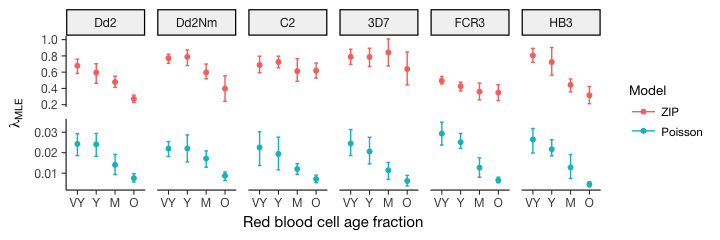

In [51]:
options(repr.plot.width = 6, repr.plot.height = 2)

fig1.old <- ggplot(filter(invasion.long, Age.Short != 'P'), aes(x = Age, y = lambda.hat, colour = Model)) + 
  stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0.2, size = 0.4) + 
  stat_summary(fun.y = mean, geom = "point", size = 1) + 
  facet_grid(Model ~ Strain, scales = "free_y") + 
  labs(y = expression(lambda[MLE]), x = "Red blood cell age fraction") + 
  my.theme + 
  theme(
    strip.text.y = element_blank()
  )

fig1.old

ggsave("../figures/comparing-model-estimates-by-strain.pdf", width = 6, height = 2)

In [52]:
plot.lambda.mle <- function(model.name, title) {

  ggplot(filter(invasion.long, (Age.Short != 'P' & Model == model.name)), aes(x = Age, y = lambda.hat)) + 
    stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0.2, size = 0.4) + 
    stat_summary(fun.y = mean, geom = "point", size = 1) + 
    facet_wrap(~Strain, nrow = 1) + 
    labs(y = expression(lambda[MLE]), x = "Red blood cell age fraction") + 
    ggtitle(title) + 
    my.theme + 
    theme(
      legend.position="none",
      plot.title = element_text(size=10)
    )
}

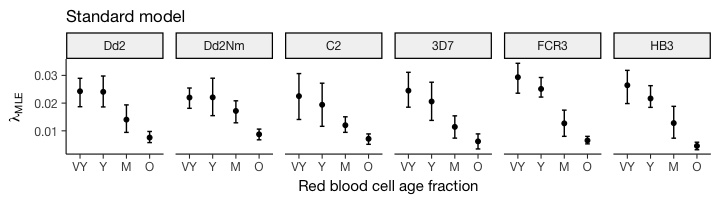

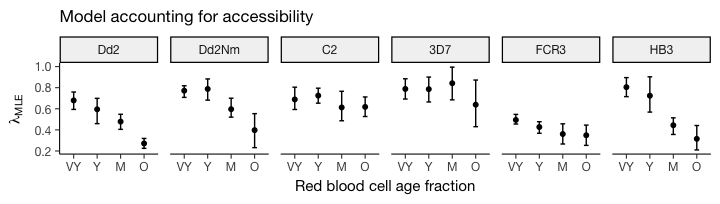

In [53]:
options(repr.plot.width = 6, repr.plot.height = 1.7)
fig1b <- plot.lambda.mle('Poisson', 'Standard model')
fig1c <- plot.lambda.mle('ZIP', 'Model accounting for accessibility')

fig1b
fig1c

## Compare SI and fraction suspectible
- SI is a measure of selectivity based on how badly the Poisson model fits
- fraction susceptible can be a measure of selectivity, assuming the ZIP model fits 

In [54]:
invasion %>%
  mutate(susc.frac = 1.0 - zip.frac) %>% 
  dplyr::select(selectivity.index, susc.frac) %>% 
  cor(method = 'spearman')

,selectivity.index,susc.frac
selectivity.index,1.000,-0.951
susc.frac,-0.951,1.000


# Strategies

See the columns we have so far

In [55]:
names(invasion)

[1] "Strain"                 "Age"                    "Age.Short"             
 [4] "Trial"                  "RBC"                    "One"                   
 [7] "Two"                    "Three"                  "Four"                  
[10] "Five"                   "infected"               "total"                 
[13] "zero"                   "parasitemia"            "normalized.parasitemia"
[16] "lambda"                 "mi.expected"            "mi.observed"           
[19] "selectivity.index"      "normalized.si"          "pois.success"          
[22] "pois.lambda"            "pois.llh"               "zip.success"           
[25] "zip.lambda"             "zip.frac"               "zip.llh"               
[28] "lrt.chisq"              "lrt.p"                  "lrt.p.clip"            
[31] "lrt.sig"

In [56]:
get.bootstrap.ci <- function(tbl, col.name) {
  ci <- tbl %>%
    pull(col.name) %>% 
    boot(statistic = function(d, i) { mean(d[i]) }, R = 1e3) %>%
    boot.ci(conf = 0.9, type = 'bca') %>%
    '$'('bca') %>%
    '['(4:5)
  tibble(
    !!(paste(col.name, 'lower', sep='.')) := ci[[1]], 
    !!(paste(col.name, 'upper', sep='.')) := ci[[2]]
  )
}

In [57]:
get.bootstrap.ci(invasion, "zip.lambda")

zip.lambda.lower,zip.lambda.upper
0.586,0.64


Compute group means for the columns we will plot.

In [58]:
group.means <- invasion %>%
  dplyr::select(Strain, Age, zip.lambda, zip.frac, normalized.parasitemia) %>%
  group_by(Strain, Age) %>%
  summarise_all(funs(mean))

zip.lambda.ci <- invasion %>%
  group_by(Strain, Age) %>%
  group_modify(~ get.bootstrap.ci(.x, 'zip.lambda'))

zip.frac.ci <- invasion %>%
  group_by(Strain, Age) %>%
  group_modify(~ get.bootstrap.ci(.x, 'zip.frac'))

In [59]:
group.means %<>% 
  inner_join(zip.lambda.ci, by = c("Strain", "Age")) %>%
  inner_join(zip.frac.ci, by = c("Strain", "Age"))

In [60]:
group.means %>% head(7)

Strain,Age,zip.lambda,zip.frac,normalized.parasitemia,zip.lambda.lower,zip.lambda.upper,zip.frac.lower,zip.frac.upper
Dd2,Positive,0.640,0.968,1.000,0.569,0.699,0.963,0.972
Dd2,Very Young,0.679,0.962,1.180,0.588,0.741,0.951,0.972
Dd2,Young,0.595,0.959,1.183,0.472,0.679,0.951,0.964
Dd2,Medium,0.479,0.969,0.740,0.414,0.544,0.960,0.979
Dd2,Old,0.271,0.971,0.452,0.236,0.313,0.965,0.977
Dd2Nm,Positive,0.576,0.969,1.000,0.531,0.605,0.964,0.974
Dd2Nm,Very Young,0.772,0.971,1.135,0.705,0.807,0.968,0.977


Also annotate strains as being sialic-acid dependent or independent.

In [61]:
group.means %<>%
  mutate(
    sa.dependent = Strain %in% c("FCR3", "Dd2", "C2") 
  )

In [62]:
group.means

Strain,Age,zip.lambda,zip.frac,normalized.parasitemia,zip.lambda.lower,zip.lambda.upper,zip.frac.lower,zip.frac.upper,sa.dependent
Dd2,Positive,0.640,0.968,1.000,0.569,0.699,0.963,0.972,TRUE
Dd2,Very Young,0.679,0.962,1.180,0.588,0.741,0.951,0.972,TRUE
Dd2,Young,0.595,0.959,1.183,0.472,0.679,0.951,0.964,TRUE
Dd2,Medium,0.479,0.969,0.740,0.414,0.544,0.960,0.979,TRUE
Dd2,Old,0.271,0.971,0.452,0.236,0.313,0.965,0.977,TRUE
Dd2Nm,Positive,0.576,0.969,1.000,0.531,0.605,0.964,0.974,FALSE
Dd2Nm,Very Young,0.772,0.971,1.135,0.705,0.807,0.968,0.977,FALSE
Dd2Nm,Young,0.788,0.972,1.101,0.682,0.852,0.967,0.980,FALSE
Dd2Nm,Medium,0.596,0.970,0.953,0.534,0.704,0.963,0.977,FALSE
Dd2Nm,Old,0.398,0.975,0.528,0.255,0.538,0.970,0.980,FALSE


## Specialist and generalists

Three takeaways:

1. As we go to older age fractions, points move toward the origin.
2. Within each age fraction, there are specialist (lower right) and generalist (upper left) strains.
3. Each strain responds to aging differently (*even within specialists and generalists*).

Warning message:
“Ignoring unknown parameters: width”

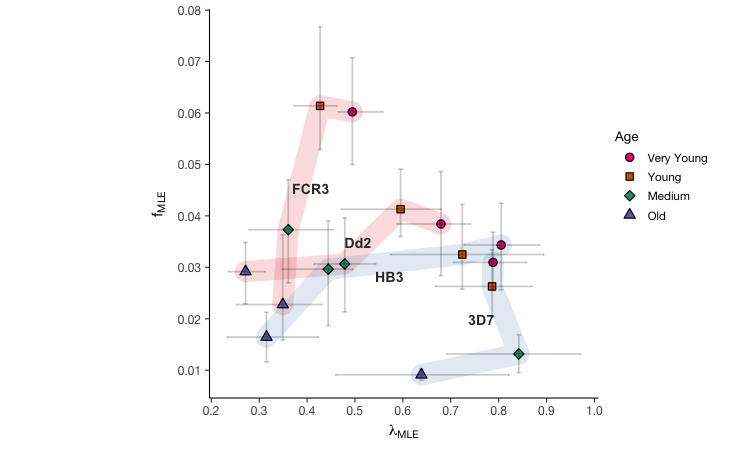

In [68]:
x <- 1.25
w <- 5*x
h <- 3*x
options(repr.plot.width = w, repr.plot.height = h)

lab.lines <- c("FCR3", "HB3", "Dd2", "3D7")
lab.means <- filter(group.means, Age != "Positive", Strain %in% lab.lines)
lab.label.data <- lab.means %>% 
  dplyr::select(Strain, zip.lambda, zip.frac) %>% 
  group_by(Strain) %>% 
  summarise_each(funs(mean)) %>% 
  ungroup()
  
fig2b <- ggplot(lab.means, aes(x = zip.lambda, y = 1.0 - zip.frac, group = Strain)) + 
  geom_path(aes(color = sa.dependent), alpha = .15, size = 6, lineend = "round", linejoin = "round", show.legend = FALSE) + 
  geom_point(aes(fill = Age, shape = Age), size = 2, stroke = 0.5) + 
  #geom_text_repel(aes(label = paste0(Strain)), force = 8,
  #                color = 'black', alpha = 0.7, size = 2.5, show.legend = FALSE) + 
  geom_errorbar(aes(ymin=1 - zip.frac.upper, ymax=1 - zip.frac.lower), width=.01, alpha=0.2) +
  geom_errorbarh(aes(xmin=zip.lambda.lower, xmax=zip.lambda.upper), width=.01 , alpha=0.2) +
  geom_text(data = lab.label.data, aes(label = Strain, x = zip.lambda, y = 1.0 - zip.frac), 
            size = 3, color = "grey20", fontface = 'bold') + 

  scale_y_continuous(breaks = seq(0, 0.1, by = 0.01)) + 
  scale_x_continuous(breaks = seq(0, 1.0, by = 0.1)) +
  #ylim(0, 0.07) + 
  #xlim(0.25, 1.0) +
  #scale_alpha_discrete(range = c(1, 0.5)) + 
  scale_fill_manual(values = brewer.pal(n = 4, name = "Dark2")[c(4,2,1,3)]) +
  scale_color_manual(values = brewer.pal(n = 3, name = "Set1")[c(2, 1)]) +
  scale_shape_manual(values = c(21, 22, 23, 24)) + 
  #scale_alpha_discrete(range = c(0.3, 0.1), guide = 'none') + 
  labs(y = expression(f[MLE]), 
       x = expression(lambda[MLE])) + 
  my.theme +
  theme(aspect.ratio=1, 
        #legend.box.background = element_rect(linetype = "solid", size = 0.7, color = "grey30"),
        legend.position = c(1.3, 1),
        legend.justification = c(1, 2))
  #facet_wrap(~sa.dependent, nrow=1)


fig2b

#ggsave("../figures/lambda-vs-p-generalist-vs-specialists-v4.pdf", width = w, height = w)

### In whole blood
Look at variation in strategy in the pooled age fractions. (Used to justify our simulations later on, which looks at invasion in whole blood, not in any particular age fraction).

Warning message:
“Ignoring unknown parameters: force”

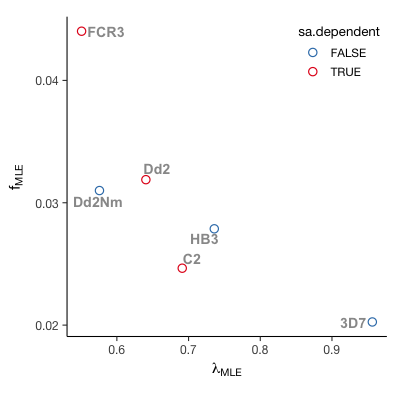

In [64]:
w <- 3.3
options(repr.plot.width = w, repr.plot.height = w)

wb.means <- filter(group.means, Age == "Positive")
wb.label.data <- wb.means %>% 
  dplyr::select(Strain, zip.lambda, zip.frac) %>% 
  group_by(Strain) %>% 
  summarise_each(funs(mean)) %>% 
  ungroup()
  
ggplot(wb.means, aes(x = zip.lambda, y = 1.0 - zip.frac, group = Strain)) + 
  #geom_path(aes(color = sa.dependent), size = 4, 
  #          alpha = 0.10, lineend = "round", linejoin = "round", show.legend = FALSE) + 
  geom_point(aes(color = sa.dependent), size = 2, stroke = 0.5, shape = 21, force = 12) + 
  #geom_text_repel(aes(label = paste0(Strain)), force = 8,
  #                color = 'black', alpha = 0.7, size = 2.5, show.legend = FALSE) + 
  geom_text_repel(data = wb.label.data, aes(label = Strain, x = zip.lambda, y = 1.0 - zip.frac), 
            size = 3, color = "grey60", fontface = 'bold') + 
  scale_y_continuous(breaks = seq(0, 0.1, by = 0.01)) + 
  scale_x_continuous(breaks = seq(0, 1.0, by = 0.1)) +
  scale_fill_manual(values = brewer.pal(n = 5, name = "Dark2")[c5]) +
  scale_color_manual(values = brewer.pal(n = 3, name = "Set1")[c(2, 1)]) +
  labs(y = expression(f[MLE]), 
       x = expression(lambda[MLE]), 
       fill = "Age fraction", 
       alpha = "Age fraction") + 
  my.theme +
  theme(aspect.ratio=1, 
        legend.position = c(1, 1),
        legend.justification = c(1, 1))


#ggsave("../figures/lambda-vs-p-generalist-vs-specialists-whole-blood.pdf", width = w, height = w)

## Shifting strategies

Looking at two isogenic strain pairs discordant in their sialic acid dependency.

Warning message:
“Ignoring unknown parameters: width”

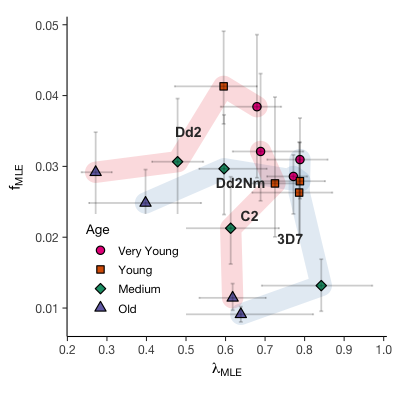

In [65]:
w <- 3.3
options(repr.plot.width = 3.3, repr.plot.height = 3.3)

isogenic.strains <- c("Dd2", "Dd2Nm", "C2", "3D7")
isogenic.means <-  filter(group.means, Age != "Positive", Strain %in% isogenic.strains)
isogenic.label.data <- isogenic.means %>% 
  dplyr::select(Strain, zip.lambda, zip.frac) %>% 
  group_by(Strain) %>% 
  summarise_each(funs(mean)) %>% 
  ungroup()

fig2c <- ggplot(isogenic.means, aes(x = zip.lambda, y = 1.0 - zip.frac, group = Strain)) + 
  geom_path(aes(color = sa.dependent), alpha = 0.15, size = 6, lineend = "round", linejoin = "round", show.legend = FALSE) + 
  geom_point(aes(fill = Age, shape = Age), size = 2, stroke = 0.5) + 
  #geom_text_repel(aes(label = paste0(Strain)), force = 8,
  #                color = 'black', alpha = 0.7, size = 2.5, show.legend = FALSE) + 
  geom_errorbar(aes(ymin=1 - zip.frac.upper, ymax=1 - zip.frac.lower), width=.01, alpha=0.2) +
  geom_errorbarh(aes(xmin=zip.lambda.lower, xmax=zip.lambda.upper), width=.01 , alpha=0.2) +
  geom_text(data = isogenic.label.data, aes(label = Strain, x = zip.lambda, y = 1.0 - zip.frac), 
            size = 3, color = "grey20", fontface = 'bold') +
  scale_y_continuous(breaks = seq(0, 0.1, by = 0.01)) + 
  scale_x_continuous(breaks = seq(0, 1.0, by = 0.1)) +
  scale_shape_manual(values = c(21, 22, 23, 24)) + 
  #scale_alpha_discrete(range = c(0.3, 0.1), guide = 'none') +  
  scale_fill_manual(values = brewer.pal(n = 4, name = "Dark2")[c(4,2,1,3)]) +
  scale_color_manual(values = brewer.pal(n = 3, name = "Set1")[c(2, 1)]) + 
  labs(y = expression(f[MLE]), 
       x = expression(lambda[MLE])) + 
  my.theme +
  theme(aspect.ratio=1, 
        #legend.box.background = element_rect(linetype = "solid", size = 0.8, color = "grey60"),
        legend.position = c(0.03, 0.03),
        legend.justification = c(0, 0))

fig2c

#ggsave("../figures/lambda-vs-p-isogenic-pairs-v3.pdf", width = w, height = w)

## All the strains, by age

Warning message:
“Ignoring unknown parameters: width”

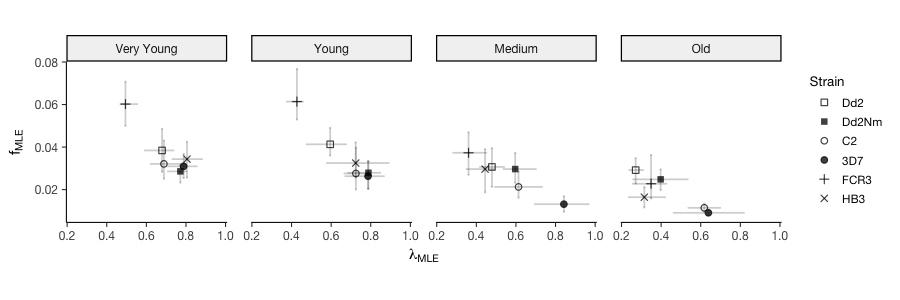

In [115]:
x <- 1.25
w <- 6*x
h <- 2*x
options(repr.plot.width = w, repr.plot.height = h)

all.lines <- c("FCR3", "HB3", "Dd2", "3D7", "Dd2Nm", "C2")
all.means <- filter(group.means, Age != "Positive", Strain %in% all.lines)
all.label.data <- all.means %>% 
  dplyr::select(Strain, zip.lambda, zip.frac) %>% 
  group_by(Strain) %>% 
  summarise_each(funs(mean)) %>% 
  ungroup()
  
fig2ab <- ggplot(all.means, aes(x = zip.lambda, y = 1.0 - zip.frac)) + 
  facet_wrap(~Age, nrow=1) + 
  geom_point(aes(shape = Strain), size = 1.5, alpha = 0.75, stroke = 0.5) + 
  geom_errorbar(aes(ymin=1 - zip.frac.upper, ymax=1 - zip.frac.lower), width=.01, alpha=0.2) +
  geom_errorbarh(aes(xmin=zip.lambda.lower, xmax=zip.lambda.upper), width=.01 , alpha=0.2) +
  scale_y_continuous(breaks = seq(0, 0.08, by = 0.02)) + 
  scale_x_continuous(breaks = seq(0, 1.0,  by = 0.2)) +
  scale_shape_manual(values = c(0, 15, 1, 19, 3, 4)) + 
  labs(y = expression(f[MLE]), 
       x = expression(lambda[MLE])) + 
  my.theme +
  theme(aspect.ratio=1, 
        panel.spacing.x=unit(1, "lines"))
fig2ab

ggsave("../figures/lambda-vs-p-all-by-age.pdf", width = w, height = w)

# Field isolates

## Fitting models

In [288]:
field.data %<>%
  by_row(..f = fit.pois,  .collate = 'cols') %>% # column names have "1" appended
  subset(select = which(!duplicated(colnames(.), fromLast = TRUE)))  # if we fit more than once, column names will be duplicated. keep only the more recent set of columns

<simpleError in optim(par = vstart, fn = fnobj, fix.arg = fix.arg, obs = data,     gr = gradient, ddistnam = ddistname, hessian = TRUE, method = meth,     lower = lower, upper = upper, ...): non-finite finite-difference value [1]>
<simpleError in optim(par = vstart, fn = fnobj, fix.arg = fix.arg, obs = data,     gr = gradient, ddistnam = ddistname, hessian = TRUE, method = meth,     lower = lower, upper = upper, ...): non-finite finite-difference value [1]>
<simpleError in optim(par = vstart, fn = fnobj, fix.arg = fix.arg, obs = data,     gr = gradient, ddistnam = ddistname, hessian = TRUE, method = meth,     lower = lower, upper = upper, ...): non-finite finite-difference value [1]>
<simpleError in optim(par = vstart, fn = fnobj, fix.arg = fix.arg, obs = data,     gr = gradient, ddistnam = ddistname, hessian = TRUE, method = meth,     lower = lower, upper = upper, ...): non-finite finite-difference value [1]>
<simpleError in optim(par = vstart, fn = fnobj, fix.arg = fix.arg, obs = dat

In [289]:
field.data %<>%
  by_row(..f = fit.zip,  .collate = 'cols', mu = 0.005, sigma = 1e-5) %>% # column names have "1" appended
  subset(select = which(!duplicated(colnames(.), fromLast = TRUE)))  # if we fit more than once, column names will be duplicated. keep only the more recent set of columns

In [290]:
field.data %>% filter(!zip.success1)

Strain,Age,Age.Short,One,Two,Three,Four,Five,RBC,infected,total,zero,parasitemia,pois.success1,pois.lambda1,pois.llh1,zip.success1,zip.lambda1,zip.frac1,zip.llh1


In [291]:
field.data %>% filter(!pois.success1)

Strain,Age,Age.Short,One,Two,Three,Four,Five,RBC,infected,total,zero,parasitemia,pois.success1,pois.lambda1,pois.llh1,zip.success1,zip.lambda1,zip.frac1,zip.llh1
P46,Old,O,1.333,0.000,0.000,0.000,0,752,1.333,6768,6767,0.0001971,FALSE,-1,-1,TRUE,0.00019792,0.00447,-12.70970571
P54,Old,O,7.667,1.000,0.000,0.000,0,782,8.667,7041,7032,0.0012348,FALSE,-1,-1,TRUE,0.22259934,0.99383,-69.90619347
P98,Old,O,6.333,0.667,0.333,0.333,0,772,7.667,6945,6937,0.0011105,FALSE,-1,-1,TRUE,0.55698022,0.99742,-65.58212941
T15,Medium,M,7.667,0.333,0.000,0.000,0,760,8.000,6837,6829,0.0011724,FALSE,-1,-1,TRUE,0.08226999,0.98519,-63.39558797
T15,Old,O,5.000,0.000,0.000,0.000,0,786,5.000,7074,7069,0.0007124,FALSE,-1,-1,TRUE,0.00070944,0.00376,-41.27372396
T18,Medium,M,9.667,0.333,0.000,0.000,0,758,10.000,6825,6815,0.0014624,FALSE,-1,-1,TRUE,0.06591327,0.97703,-76.71919326
T18,Old,O,1.333,0.000,0.000,0.000,0,765,1.333,6882,6881,0.0001940,FALSE,-1,-1,TRUE,0.00019464,0.00469,-12.73197730
T22,Old,O,6.333,1.333,0.000,0.000,0,774,7.667,6963,6955,0.0011030,FALSE,-1,-1,TRUE,0.32990248,0.99608,-63.58598881
T25,Young,Y,0.333,0.000,0.000,0.000,0,750,0.333,6747,6747,0.0000494,FALSE,-1,-1,TRUE,0.00004965,0.00489,-3.63848855
T25,Medium,M,0.000,0.000,0.000,0.000,0,750,0.000,6750,6750,0.0000000,FALSE,-1,-1,TRUE,0.00000001,0.97860,-0.00000144


For the Poisson model, all bad fits had less than 10 infected cells.

In [292]:
field.data %>% filter(!pois.success1, infected > 10)

Strain,Age,Age.Short,One,Two,Three,Four,Five,RBC,infected,total,zero,parasitemia,pois.success1,pois.lambda1,pois.llh1,zip.success1,zip.lambda1,zip.frac1,zip.llh1


For the Poisson model, all good fits had more than 10 infected cells.

In [293]:
field.data %>% filter(pois.success1, infected <= 10)

Strain,Age,Age.Short,One,Two,Three,Four,Five,RBC,infected,total,zero,parasitemia,pois.success1,pois.lambda1,pois.llh1,zip.success1,zip.lambda1,zip.frac1,zip.llh1


Rename columns to remove the trailing 1

In [294]:
names(field.data) %<>% 
  map(~ if (endsWith(., "1")) substr(., 1, nchar(.) - 1) else .)

In [295]:
field.data %>% filter (pois.success) %>% group_by(Age)%>% select(Age, Strain) %>% summarise(num_strains = n_distinct(Strain))

Age,num_strains
Very Young,20
Young,18
Medium,16
Old,12


In [296]:
field.data %>% count()

n
80


## Strategies

See the overall trend with age, and the variety of strain-specific trade-offs within each age group.

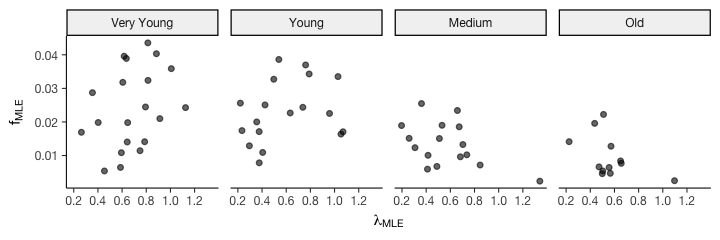

In [297]:
options(repr.plot.width = 6, repr.plot.height = 2)

fig4a <- ggplot(filter(field.data, Age != "Positive", pois.success), 
       aes(x = zip.lambda, 
           y = 1.0 - zip.frac, 
           group = Strain)) + 
  #geom_path(color = 'black', size = 1.5, 
  #          alpha = 0.2, lineend = "round", linejoin = "round", show.legend = FALSE) + 
  geom_point(fill = 'black', size = 1.3, shape = 21, alpha = 0.6, show.legend = FALSE) + 
  #geom_text_repel(aes(label = paste0(Strain)), force = 8,
  #                color = 'black', alpha = 0.7, size = 2.5, show.legend = FALSE) + 
  scale_y_continuous(breaks = seq(0, 0.1, by = 0.01)) + 
  scale_x_continuous(breaks = seq(0, 1.4, by = 0.2)) +
  scale_alpha_discrete(range = c(1, 0.5)) + 
  scale_fill_manual(values = brewer.pal(n = 4, name = "Dark2")[c(4,2,1,3)]) +
  labs(y = expression(f[MLE]), 
       x = expression(lambda[MLE]), 
       fill = "Age fraction", 
       alpha = "Age fraction") + 
  facet_wrap(~ Age, nrow = 1) + 
  my.theme +
  theme(aspect.ratio = 1)

fig4a

ggsave("../figures/lambda-vs-p-field-isolates-by-age-no-color.pdf", width = 6, height = 2)

See the variety of strain-specific responses to age. Exclude strains where the Poisson was not fit (infected < 10). Even though ZIP was successfully fit, some of the estimates seem off.

In [298]:
names(field.data)

[1] "Strain"       "Age"          "Age.Short"    "One"          "Two"         
 [6] "Three"        "Four"         "Five"         "RBC"          "infected"    
[11] "total"        "zero"         "parasitemia"  "pois.success" "pois.lambda" 
[16] "pois.llh"     "zip.success"  "zip.lambda"   "zip.frac"     "zip.llh"

In [299]:
field.data.vy.o <- field.data %>%
  group_by(Strain) %>%
  filter(Age %in% c("Very Young", "Old"), pois.success) %>%
  filter(n() == 2) %>%
  ungroup()
field.data.vy.o %>% head(4)

Strain,Age,Age.Short,One,Two,Three,Four,Five,RBC,infected,total,zero,parasitemia,pois.success,pois.lambda,pois.llh,zip.success,zip.lambda,zip.frac,zip.llh
P102,Very Young,VY,89.7,29.00,7.667,0.000,0,767,126.3,6906,6780,0.01828,TRUE,0.02471,-836,TRUE,0.635,0.961,-727
P102,Old,O,13.3,5.00,0.333,0.000,0,754,18.7,6789,6770,0.00275,TRUE,0.00358,-165,TRUE,0.556,0.994,-142
P106,Very Young,VY,87.0,46.67,21.333,0.667,0,760,155.7,6837,6681,0.02277,TRUE,0.03613,-1140,TRUE,1.007,0.964,-900
P106,Old,O,13.0,3.67,0.333,0.000,0,757,17.0,6813,6796,0.00250,TRUE,0.00313,-147,TRUE,0.472,0.993,-129


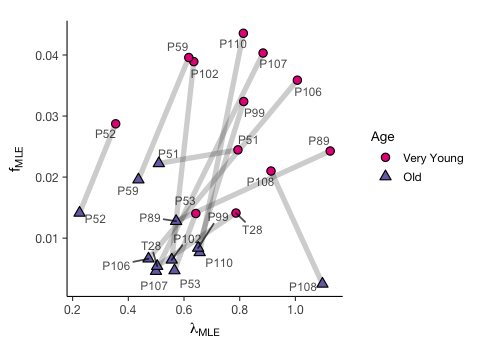

In [306]:
options(repr.plot.width = 4, repr.plot.height = 3)

fig4b <- ggplot(field.data.vy.o, aes(x = zip.lambda, y = 1.0 - zip.frac, group = Strain)) + 
  geom_path(color = 'black', size = 1.5, 
            alpha = 0.2, lineend = "round", linejoin = "round", show.legend = FALSE) + 
  geom_point(aes(fill = Age, shape = Age), size = 2, show.legend = TRUE) + 
  geom_text_repel(aes(label = paste0(Strain)), force = 15,
                  color = 'black', alpha = 0.7, size = 2.5, show.legend = FALSE) + 
  scale_y_continuous(breaks = seq(0, 0.1, by = 0.01)) + 
  scale_x_continuous(breaks = seq(0, 1.2, by = 0.2)) +
  scale_alpha_discrete(range = c(1, 0.5)) + 
  scale_fill_manual(values = brewer.pal(n = 4, name = "Dark2")[c(4,3)]) +
  scale_shape_manual(values = c(21, 24)) + 
  labs(y = expression(f[MLE]), 
       x = expression(lambda[MLE])) + 
  my.theme +
  theme(aspect.ratio = 1, 
        legend.title = element_text(size = 8), 
        legend.text = element_text(size = 7),
        #legend.box.background = element_rect(linetype = "solid", size = 0.8, color = "grey60"),
        #legend.position = c(0.015, 1),
        legend.position = 'right')
        #legend.justification = c(0, 1))

fig4b

ggsave("../figures/lambda-vs-p-field-isolates.pdf", width = 4, height = 3)

# Characterizing strategies 

For plotting later, code to set up a blank set of axes with arrows

In [189]:
blank.axes <-
  ggplot() +
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 0), size = 0.35, lineend = 'round',
               arrow = arrow(length = unit(0.2, "cm"), type="closed", angle = 17)) + 
  geom_segment(aes(y = 0, yend = 1, x = 0, xend = 0), size = 0.35, lineend = 'round',
               arrow = arrow(length = unit(0.2, "cm"), type="closed", angle = 17)) + 
  scale_y_continuous(limits = c(0, 1), expand = c(0, 0)) +
  scale_x_continuous(limits = c(0, 1), expand = c(0, 0)) +
  my.theme +
  theme(aspect.ratio = 1,
        axis.line  = element_blank(),
        axis.ticks = element_blank(),
        axis.text  = element_blank(),
        axis.title = element_text(hjust = 0.5))

## Generalists vs specialists

In [190]:
fake.strategies <- tibble(
    f = c(0.80, 0.70, 0.80, 0.70,
          0.44, 0.55, 0.51, 0.44,
          0.28, 0.18, 0.18, 0.23),
    l = c(0.28, 0.18, 0.18, 0.23, 
          0.51, 0.55, 0.44, 0.44,
          0.80, 0.70, 0.80, 0.70)
  ) %>% 
  mutate(
    t = ifelse(f >= 0.7, 'G', ifelse(f < 0.3, 'S', 'I'))
  )

fake.strategy.labels <- fake.strategies %>%
  group_by(t) %>%
  summarise_each(funs(mean)) %>%
  ungroup() %>%
  mutate(
    label = recode(t, G = "Generalist", I = "Intermediate", S = "Specialist")
  )

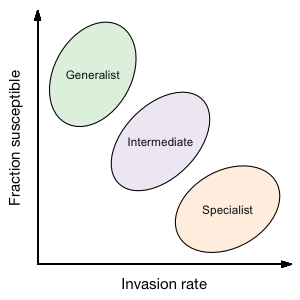

In [191]:
options(repr.plot.width = 2.5, repr.plot.height = 2.5)

p1 <- blank.axes %+% fake.strategies + 
  aes(x = l, y = f) + 
  stat_ellipse(aes(fill = t, group = t), color = 'grey40', geom = "polygon", type = "norm", level = 0.917, size = 0, alpha = 0.25) + 
  stat_ellipse(aes(group = t), color = 'black', type = "norm", level = 0.917, size = 0.3, alpha = 1) + 
  #geom_point(shape = 16, size = 0.8, alpha = 0.8) +
  geom_text(data = fake.strategy.labels, aes(x = l, y = f, label = label),
           color = "grey10", size = 2.5, hjust = 0.5, vjust = 0.5) +
  scale_fill_brewer(palette = 'Accent', guide = FALSE) +
  scale_color_brewer(palette = 'Accent', guide = FALSE) + 
  labs(y = "Fraction susceptible", x = "Invasion rate") 

fig3a <- ggplot_gtable(ggplot_build(p1))
fig3a$layout$clip[fig3a$layout$name=="panel"] <- "off"

grid.draw(fig3a)

ggsave(fig3a, file = '../figures/mock-generalist-vs-specialist.pdf', width = 2.5, height = 2.5)

## Response to aging

In [249]:
fake.age.response <- tibble(
  f      = c(0.75, 0.75, 0.35, 0.48) - 0.1,
  l      = c(0.75, 0.35, 0.75, 0.48) - 0.1,
  f.text = c(0.78, 0.75, 0.32, 0.46) - 0.1,
  l.text = c(0.75, 0.31, 0.75, 0.46) - 0.1,
  age   = c('very young', 'old', 'old', 'old'),
  id     = c(0, 1, 2, 3)
)

In [250]:
get.arrow.data <- function(k) {
  start <- fake.age.response %>% filter(id == 0) %>% dplyr::select(f, l) %>% dplyr::rename(x = l, y = f)
  end   <- fake.age.response %>% filter(id == k) %>% dplyr::select(f, l) %>% dplyr::rename(xend = l, yend = f)
  cbind(start, end)
}
make.arrow <- function(k) {
  geom_segment(data = get.arrow.data(k), aes(x = x, y = y, xend = xend, yend = yend),
               size = 0.35, lineend = 'round',
               arrow = arrow(length = unit(0.2, "cm"), type="closed", angle = 17))
}

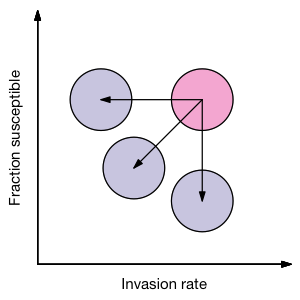

In [257]:
options(repr.plot.width = 2.5, repr.plot.height = 2.5)

p2 <- blank.axes %+% fake.age.response +
  aes(x = l, y = f) +
  #geom_text(aes(x = l.text, y = f.text, label = age), size=2.5) + 
  geom_point(aes(fill = age), shape = 21, size = 17, alpha = 0.35) +
  geom_point(shape = 1, size = 17, alpha = 1, show.legend = TRUE) +
  make.arrow(1) + 
  make.arrow(2) + 
  make.arrow(3) + 
  labs(y = "Fraction susceptible", x = "Invasion rate") +
  scale_fill_manual(values = brewer.pal(n = 4, name = "Dark2")[c(3, 4)], name = 'Age fraction') +
  guides(fill=guide_legend(override.aes=list(size = 2, alpha = 0.5), reverse = TRUE)) + 
  theme(legend.position = 'none', legend.justification = c(0, 0))

fig3b <- ggplot_gtable(ggplot_build(p2))
fig3b$layout$clip[fig3b$layout$name=="panel"] <- "off"
grid.draw(fig3b)

ggsave(fig3b, file = '../figures/mock-age-response.pdf', width = 2.5, height = 2.5)

# In vivo dynamics

## ODE model description

We track three quantities: $P$, the number of permissive RBCs (accessible and susceptible), $U$, the number of unpermissive RBCs, $I$, the number of infected RBCs, and $Z$, the number of merozoites.

We model the infection process with the following system of differential equations:

$\dot{P} =f\omega - \beta Z P - \mu P$

$\dot{U} = (1 - f)\omega - \mu U$

$\dot{I} = \beta Z P - \mu_I I$

$\dot{Z} = m\mu_I I - \beta Z P - \mu_Z Z$

$\omega$ is the continuous influx of RBCs (e.g. hematopoiesis), of which fraction $f$ are permissive. $\mu$ is the death rate shared by both permissive and unpermissive RBCs, $\mu_I$, for infected RBCs, and $\mu_Z$, for merozoites. $\beta$ is the contact rate between permissive RBCs and merozoites. $m$ is average burst size, i.e. the number of merozoites released by the rupture of an infected RBC.

As stated above, the time spent in each RBC compartment follows an exponential distribution. The age distribution of RBCs is not exponential, nor is the parasite development time in infected RBCs (approximately 48 hours). So that the waiting time each compartment is more realistic, we replace each compartment with a series of successive compartments (see http://rspb.royalsocietypublishing.org/content/268/1470/985.short).

So we have this modified system of equations:

$\dot{P_1} = f\omega - (n\mu) P_1 - \beta Z P_1$
 
$\dot{P_j} = (n\mu) P_{j - 1} - (n\mu) P_j - \beta Z P_j$, for $j = 2, \dots, n$

$\dot{U_1} = (1 - f)\omega - (n\mu) U_1$

$\dot{U_j} = (n\mu)U_{j - 1} - (n\mu) U_j$, for $j = 2, \dots, n$

$\dot{I_1} = \beta Z (\sum_{j = 1}^n P_j) - (n_I\mu_I) I_1$

$\dot{I_j} = (n_I\mu_I) I_{j - 1} - (n_I\mu_I) I_j$ for $j = 2, \dots, n_I$.

$\dot{Z} = m (n_I \mu_I I_{n_I}) - \beta Z (\sum_{j = 1}^n P_j) - \mu_Z Z$

$n$ is the number of succesive compartments for uninfected RBCs, and $n_I$ is the number of successive compartments for infected RBCs. We do not apply the same modification to the merozoite age distribution, because ???. 

## Model setup

Notes:
- 1e11 to 1e12 RBCs are produced each day, with lifespan of 100-120 days.
- For merozoite death rate, see http://www.pnas.org/content/107/32/14378.full
- The numbers in each compartments will be kept in a vector: $\mathbf{y} = (P_1, \dots, P_n, U_1, \dots, U_n, I_1, \dots I_{n_I}, Z)$.
- The model is specified using time units of days.
- RBCs are in counted by the trillion (1e12).

In [317]:
ODE.PARAMS <- c(
  N    = 25,            # unitless
  N_I  = 25,            # unitless 
  W    = 0.25,          # trillion RBCs per day
  MU   = 1 / 110 ,      # per day
  MU_I = 1 / 2 ,        # per day
  MU_Z = (24 * 60) / 5, # per day (assume merozoites survive for 5 minutes)
  M    = 15,            # merozoites per infected RBC
  F    = 0.25,          # fraction of new RBCs that are permissive
  BETA = 10             # rate of infectious contact
)

In [318]:
STATE.NAMES <- c(
  paste0('P', 1:ODE.PARAMS[['N']]), 
  paste0('U', 1:ODE.PARAMS[['N']]),
  paste0('I', 1:ODE.PARAMS[['N_I']]),
  'Z'
)
cat(STATE.NAMES)

P1 P2 P3 P4 P5 P6 P7 P8 P9 P10 P11 P12 P13 P14 P15 P16 P17 P18 P19 P20 P21 P22 P23 P24 P25 U1 U2 U3 U4 U5 U6 U7 U8 U9 U10 U11 U12 U13 U14 U15 U16 U17 U18 U19 U20 U21 U22 U23 U24 U25 I1 I2 I3 I4 I5 I6 I7 I8 I9 I10 I11 I12 I13 I14 I15 I16 I17 I18 I19 I20 I21 I22 I23 I24 I25 Z

In [319]:
ODE.DERIVATIVE <- function(t, state, parameters) {
  with(as.list(c(state, parameters)), {
    # permissive equations
    dP1 <- F * W - (N * MU) * P1 - BETA * Z * P1
    dPj <- with(list(j = 2:N), {
      paste0("N * MU * P", j - 1, " - N * MU * P", j, "- BETA * Z * P", j) %>%
        lapply(function (x) eval(parse(text = x))) %>%
        unlist()
    })

    # unpermissive equations
    dU1 <- (1 - F) * W - (N * MU) * U1
    dUj <- with(list(j = 2:N), {
      paste0("N * MU * U", j - 1, "- N * MU * U", j) %>%
        lapply(function (x) eval(parse(text = x))) %>%
        unlist()
    })

    # infected equations
    P <- state[names(state) %>% startsWith("P")] %>% unlist() %>% sum()
    dI1 = BETA * Z * P - N_I * MU_I * I1
    dIj = with(list(j = 2:N_I), {
      paste0("N_I * MU_I * I", j - 1, "- N_I * MU_I * I", j) %>%
        lapply(function (x) eval(parse(text = x))) %>%
        unlist()
    })

    # merozoite equation
    I.last <- parse(text = paste0("I", N_I))
    dZ = M * N_I * MU_I * eval(I.last) - BETA * P * Z - MU_Z * Z  

    list(c(dP1, dPj, dU1, dUj, dI1, dIj, dZ))
  })
}

##  Equilibrate hematopoesis

Start with 20 trillion RBCs. Check days needed to reach equilibrium with no infection.

In [320]:
get.start.state <- function(start.pop) {
  with(as.list(ODE.PARAMS), {
    state <- rep(0, N + N + N_I + 1)
    names(state) <- STATE.NAMES
    state[['P1']] = start.pop * F
    state[['U1']] = start.pop * (1 - F)
    state
  })
}

In [321]:
times <- seq(0, 200, by = 0.1)
state <- get.start.state(20)
eq <- ode(y = state, times = times, func = ODE.DERIVATIVE, parms = ODE.PARAMS) %>%
  data.frame() %>% 
  transmute(
    T = time,
    P = rowSums(dplyr::select(., starts_with("P"))),
    U = rowSums(dplyr::select(., starts_with("U"))),
    I = rowSums(dplyr::select(., starts_with("I"))),
    Z = Z
  )

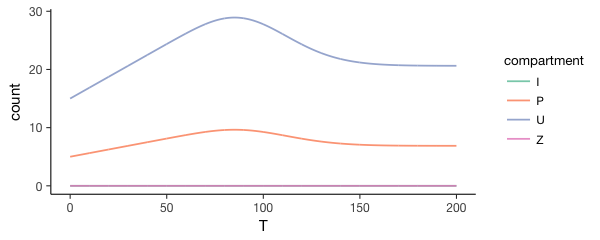

In [322]:
options(repr.plot.width = 5, repr.plot.height = 2)

eq.long <- eq %>% gather("compartment", "count", c(P, U, I, Z))
ggplot(eq.long, aes(x = T, y = count)) + 
  geom_line(aes(group = compartment, color = compartment), size = 0.5, alpha = 0.8) + 
  scale_color_brewer(palette = "Set2") + 
  my.theme

ggsave("../figures/ode-equilibration.pdf", width = 5, height = 8, units = "cm")

See equilibrium numbers of RBCs (in trillions).

In [323]:
eq %>% 
  mutate(RBC = P + U + I) %>%
  tail(6)

,T,P,U,I,Z,RBC
1996,200,6.88,20.6,0,0,27.5
1997,200,6.88,20.6,0,0,27.5
1998,200,6.88,20.6,0,0,27.5
1999,200,6.88,20.6,0,0,27.5
2000,200,6.88,20.6,0,0,27.5
2001,200,6.88,20.6,0,0,27.5


## Fraction permissive and PMR

`PMR = m * f * p`

- `m` : merozoites per schizont
- `f` : fraction of RBCs susceptible
- `p` : probability of invasion given contact with a susceptible RBC

Notes: 
1. This assumes that merozoites don't compete for the same RBC, which is reasonable given the rarity of multiply infected RBCs. 
2. For a desired `PMR`, we can determine `f` (since `m` and `p` are constants). 

The relationship between `f` and `p`, and the values we will later use for our simulations.

In [324]:
get.efficiency <- function(pmr, f) pmr / (ODE.PARAMS[['M']] * f)

In [325]:
pmrs = c(0.3, 1.25, 3)
points = tibble(
  f     = c(0.5, 0.25, 0.1), 
  pmr   = pmrs[2], 
  p     = get.efficiency(pmr, f),
  pheno = c('Generalist', 'Intermediate', 'Specialist')
)

In [326]:
fs <- seq(1e-3, 1, 1e-3)
mock.curves <- pmrs %>% 
  map(~ get.efficiency(., fs)) %>% 
  set_names(pmrs) %>% 
  as_data_frame() %>%
  mutate(f = fs) %>%
  gather("pmr", "p", 1:length(pmrs))

Warning message:
“`as_data_frame()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”

# A tibble: 3 x 3
      f pmr       p
  <dbl> <chr> <dbl>
1   0.5 0.3   0.04 
2   0.5 1.25  0.167
3   0.5 3     0.4  


Warning message:
“Removed 301 rows containing missing values (geom_path).”

Warning message:
“Removed 301 rows containing missing values (geom_path).”

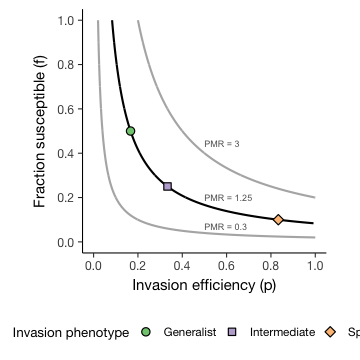

In [327]:
options(repr.plot.width = 3, repr.plot.height = 3)

mock.label.positions <- mock.curves %>% filter(abs(f - 0.5) < 1e-3)
print(mock.label.positions)

fig5a <- ggplot(mock.curves, aes(x = p, y = f, group = pmr)) +
  geom_line(aes(color = pmr), size = 0.6) +
  geom_point(data = points, aes(x = p, y = f, fill = pheno), shape = c(21, 22, 23), size = 2) + 
  geom_text(data = mock.label.positions, aes(x = f, y = p * 1.05, label = paste0("PMR = ", pmr)), size = 1.9, hjust = 0, nudge_y = 0.027, alpha = 0.7) + 
  scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2), name = 'Invasion efficiency (p)') + 
  scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2), name = 'Fraction susceptible (f)') +
  scale_color_manual(values = c('grey70', 'black', 'grey70')) + 
  scale_fill_brewer(palette = 'Accent', name = 'Invasion phenotype') + 
  guides(color=FALSE, fill = guide_legend(reverse = FALSE)) + 
  my.theme + 
  theme(aspect.ratio = 1, legend.position = 'bottom')

fig5a

ggsave("../figures/fraction-efficiency-tradeoff.pdf", width = 3, height = 3)

## Simulations

Define a function that equilibrates RBC-only dynamics, introduces sporozoites, and simulates invasion dynamics. Assuming 
- 15 sporozoites leads to 15 infected hepatocytes and 40000 merozoites per hepatocyte (from [here](http://www.bio.davidson.edu/people/sosarafova/assets/bio307/ruturakhia/page01.html)).
- A merozoite takes 5 minutes to complete invasion, starting from making RBC contact.

In [328]:
TAU = 5 / (24 * 60) # time from contact to invasion complete, in hours

In [329]:
simulate.invasion <- function (pmr, frac.susceptible, days.inv = 25, days.eq = 200) {
  params <- ODE.PARAMS
  params[['F']] = frac.susceptible
  invasion.prob = pmr / (params[['M']] * params[['F']])
  params[['BETA']] = invasion.prob / TAU
  
  # invasion-free equilibration
  eq.times <- seq(0, days.eq, 0.1)
  eq.start <- get.start.state(20)
  eq.result <- ode(y = eq.start, times = eq.times, func = ODE.DERIVATIVE, parms = params)
  
  # infect the invasion-free steady state
  inv.start <- eq.result[nrow(eq.result), 2:ncol(eq.result)] %>% unlist() # remove the time column
  inv.start[['Z']] <- 15 * 4e-8 # remember we are counting by trillions
  
  # simulate invasion dynamics
  inv.times <- seq(0, days.inv, 0.01)
  inv.result <- ode(y = inv.start, times = inv.times, func = ODE.DERIVATIVE, parms = params)

  # tag with PMR before returning
  inv.result %>% 
    data.frame() %>%
    transmute(
      T = time,
      P = rowSums(dplyr::select(., starts_with("P"))),
      U = rowSums(dplyr::select(., starts_with("U"))),
      I = rowSums(dplyr::select(., starts_with("I"))),
      Z = Z
    ) %>%
    mutate(
      pmr  = pmr,
      frac = frac.susceptible,
      p    = invasion.prob
    ) 
}

Simulate

In [330]:
dynamics <- points$f %>%
  map(~ simulate.invasion(1.25, .)) %>%
  bind_rows()

Convert to long-form for plotting

In [331]:
dynamics.long <- dynamics %>% 
  mutate(
    I.frac = I / (P + U + I)
  ) %>%
  gather("compartment", "count", c(P, U, I, Z, I.frac)) %>%
  mutate(
    frac = parse_factor(frac, levels = c(0.5, 0.25, 0.1))
  )

Plot all compartments

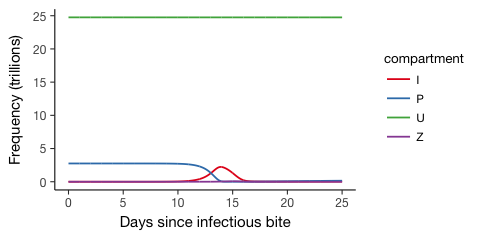

In [332]:
options(repr.plot.width = 4, repr.plot.height = 2)

ggplot(filter(dynamics.long, frac == 0.1, compartment!= 'I.frac'), aes(x = T, y = count)) + 
  geom_line(aes(color = compartment)) +
  scale_color_brewer(palette = 'Set1') + 
  scale_x_continuous(limits = c(0, NA), name = 'Days since infectious bite') + 
  scale_y_continuous(name = 'Frequency (trillions)') +
  my.theme

Plot parasitemia

# A tibble: 3 x 5
      p frac      T  count label             
  <dbl> <fct> <dbl>  <dbl> <chr>             
1 0.167 0.5    15.3 0.442  f = 0.5, p = 0.17 
2 0.333 0.25   14.7 0.211  f = 0.25, p = 0.33
3 0.833 0.1    13.9 0.0824 f = 0.1, p = 0.83 


Warning message:
“Removed 4500 rows containing missing values (geom_path).”

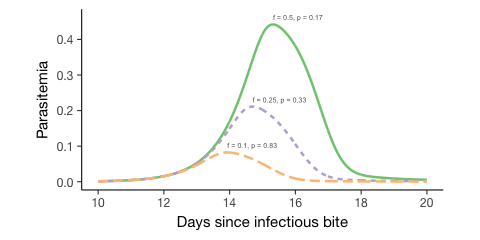

In [336]:
options(repr.plot.width = 4, repr.plot.height = 2)

label.data <- dynamics.long %>% 
  group_by(frac, compartment) %>% 
  filter(count == max(count), compartment == 'I.frac') %>% 
  ungroup() %>%
  dplyr::select(p, frac, T, count) %>%
  mutate(label = paste0('f = ', frac, ', p = ', round(p, 2)))
print(label.data)

fig5b <- ggplot(filter(dynamics.long, compartment == 'I.frac'), 
                aes(x = T, y = count, group = as.factor(frac))) + 
  geom_line(aes(linetype=frac, color=frac), show.legend = FALSE, size = 0.7) +
  geom_text(data = label.data, aes(x = T, y = count, label = label), size = 1.5, hjust = 0, nudge_y = 0.02, alpha = 0.7) + 
  scale_color_brewer(palette = 'Accent') + 
  scale_x_continuous(limits = c(10, 20), breaks = seq(10, 20, 2), name = 'Days since infectious bite') + 
  scale_y_continuous(name = 'Parasitemia') +
  my.theme + 
  theme(aspect.ratio = 0.5)
 
fig5b

#ggsave("../figures/in-vivo-dynamics-v2.pdf", width = 4, height = 2)

# Boolean-Poisson model of accessibility

The expected volume accessible (fraction) is given by

$ E[V] = 1 - \exp(-(R/r)^3hs)$,

where $R/r$ is the ratio of the burst radius relative to the RBC radius, $h$ is the hematocrit, and $s$ is the schizontemia.

In our invasion assays, $h = 2\%$, $s = 0.7\%$. Crick et al. estimated $R/r$ to be 1.5.

In [9]:
# burst.radius: relative to RBC radius
# h: hematocrit
# s: schizontemia
vol.accessible <- function(burst.radius, h, s) {1 - exp(-(burst.radius**3 * h * s))}

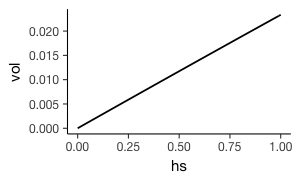

In [10]:
options(repr.plot.width = 2.5, repr.plot.height = 1.5)

hs <- seq(0, 1, by = 0.01)
df <- data.frame(hct = hs, vol = vol.accessible(1.5, hs, 0.007))
ggplot(df, aes(x = hs, y = vol)) +
  geom_line() + 
  my.theme

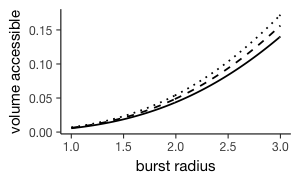

In [20]:
options(repr.plot.width = 2.5, repr.plot.height = 1.5)

rs <- seq(1, 3, by = 0.01)
df <- data.frame(rad = rs, v1 = vol.accessible(rs, 0.8, 0.007), v2 = vol.accessible(rs, 0.9, 0.007), v3 = vol.accessible(rs, 1.0, 0.007))
ggplot(df) +
  geom_line(aes(x = rad, y = v1), linetype=1) + 
  geom_line(aes(x = rad, y = v2), linetype=2) + 
  geom_line(aes(x = rad, y = v3), linetype=3) + 
  ylab('volume accessible') + 
  xlab('burst radius') + 
  my.theme

In [181]:
vol.accessible(2.5, 1, 0.007)

[1] 0.104

In [184]:
vol.accessible(5, 1, 0.007)

[1] 0.583

# Multipanel Figures
Encapsulate preceding plotting code and reuse them here with `arrangeGrob` to create multi-panel figures.

## Figure 1

In [94]:
# options(repr.plot.width = 6, repr.plot.height = 2)
# fig1
# ggsave('../figures/paper/fig1.pdf', width = 6, height = 2)

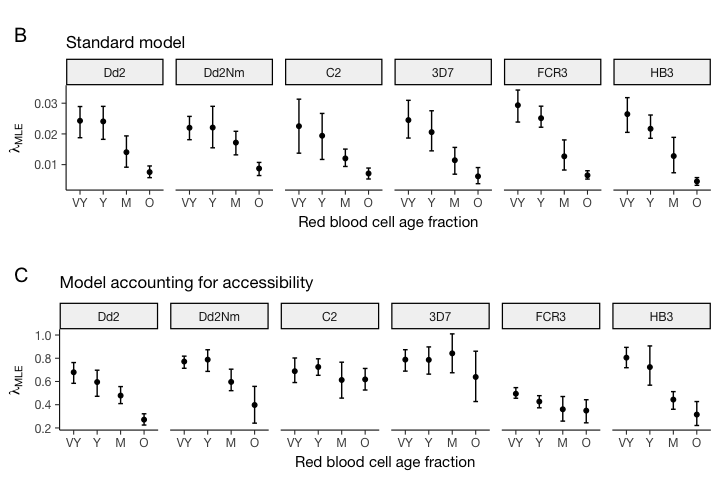

In [95]:
options(repr.plot.width = 6, repr.plot.height = 4)
b <- fig1b %>% label.grob("B", y = -0.3)
c <- fig1c %>% label.grob("C", y = -0.3)
g <- arrangeGrob(b, c, nrow = 2)

grid.draw(g)
ggsave(g, file = '../figures/paper/fig1bc.pdf', width = 6, height = 4)

##  Figure 2

Fragile code that labels two plots that have been combined to share a legend. (Cannot label the plots first, and then combine to share a legend because labeling turns ggplot objects in grobs, but the share legend function expects ggplot objects.)

In [342]:
label.grob.2 <- function(grob, labels, grob.height, x1 = 0.02, x2 = 0.02, y = -0.3, size = 12) {
  t1 <- textGrob(labels[[1]], x = x1, y = y, hjust = 0, gp = gpar(fontsize = size))
  t2 <- textGrob(labels[[2]], x = x2, y = y, hjust = 0, gp = gpar(fontsize = size))
  layout <- rbind(c(1, 2), 
                  c(3, 3))
  g.table <- arrangeGrob(t1, t2, grob, layout_matrix = layout, heights = c(1, grob.height))
  
  g.table$layout[c(1, 2), 'z'] = 99 # set the panel labels to be on top
  g.table
}

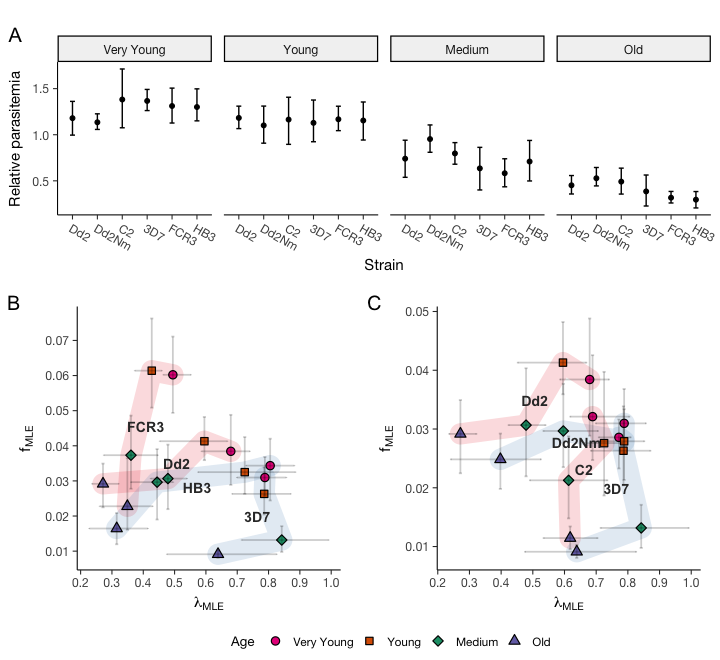

In [343]:
options(repr.plot.width = 6, repr.plot.height = 5.5)

a <- fig2a %>% label.grob("A", x = 0.012)

fig2bc.theme <- theme(legend.justification = c(0.58, 0))
bc <- grid_arrange_shared_legend(fig2b + fig2bc.theme, fig2c, position = 'bottom') %>% 
  label.grob.2(c("B", "C"), grob.height = 20)

g <- arrangeGrob(a, bc, heights = c(2.2, 3))
grid.draw(g)

ggsave(g, file = '../figures/paper/fig2.pdf', width = 6, height = 5.5)

## Reorganization of Figs 2 and 3

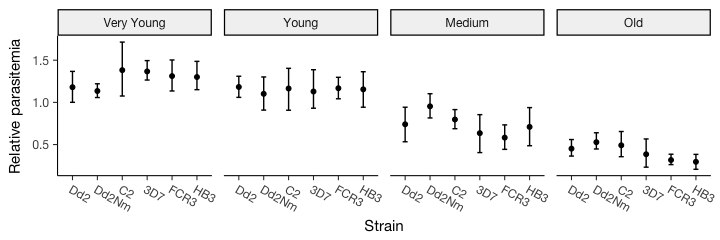

In [344]:
options(repr.plot.width = 6, repr.plot.height = 2)

grid.draw(fig2a)

ggsave(fig2a, file = '../figures/paper/parasitemia-vs-age-by-strain.pdf', width = 6, height = 2)

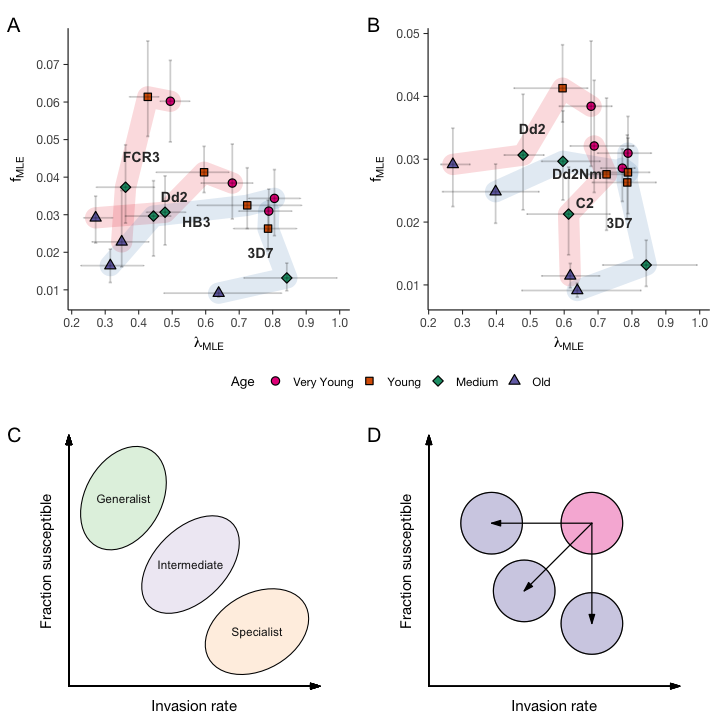

In [345]:
options(repr.plot.width = 6, repr.plot.height = 6)

fig2bc.theme <- theme(legend.justification = c(0.58, 0))
bc <- grid_arrange_shared_legend(fig2b + fig2bc.theme, fig2c, position = 'bottom') %>% 
  label.grob.2(c("A", "B"), grob.height = 20)

c <- fig3a %>% label.grob("C", y = -0.3)
d <- fig3b %>% label.grob("D", y = -0.3)
cd <- arrangeGrob(c, d, ncol = 2, heights = c(10))

g <- arrangeGrob(bc, cd, nrow = 2, heights = c(12.5, 10))

grid.draw(g)

ggsave(g, file = '../figures/paper/fig2-new.pdf', width = 6, height = 6)

## Figure 3

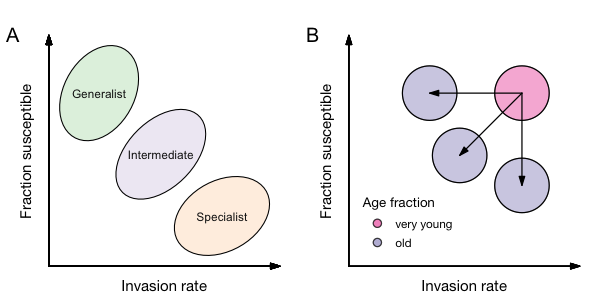

In [100]:
options(repr.plot.width = 5, repr.plot.height = 2.5)
a <- fig3a %>% label.grob("A", y = -0.3)
b <- fig3b %>% label.grob("B", y = -0.3)
g <- arrangeGrob(a, b, ncol = 2)

grid.draw(g)
ggsave(g, file = '../figures/paper/fig3.pdf', width = 5, height = 2.5)

## Figure 4

In [307]:
class(a)

[1] "gtable" "gTree"  "grob"   "gDesc"

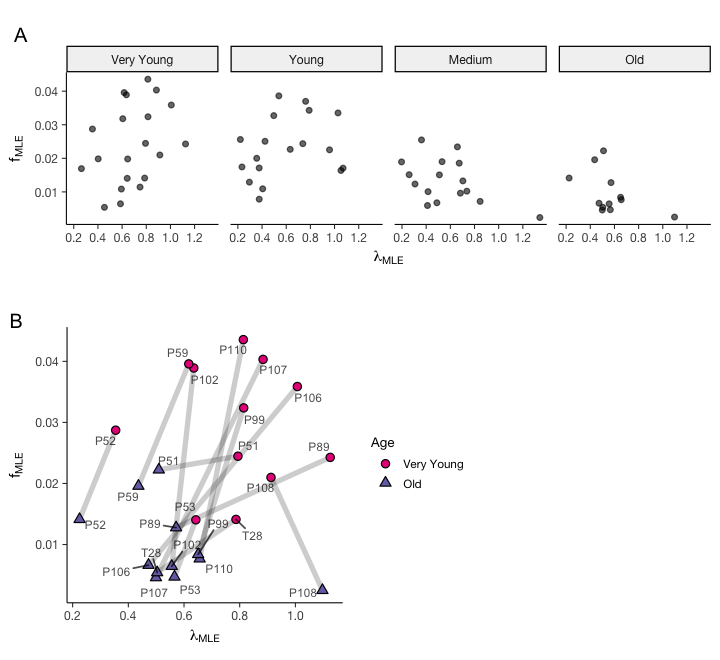

In [308]:
options(repr.plot.width = 6, repr.plot.height = 5.5)

a <- fig4a %>% label.grob("A", y = -0.3)
b <- fig4b %>% label.grob("B", y = -0.3)
g <- arrangeGrob(a, b, rectGrob(gp=gpar(col=NA)), heights = c(2.3, 3), layout_matrix = rbind(c(1, 1, 1), c(2, 2, 3)))

grid.draw(g)
ggsave(g, file = '../figures/paper/fig4.pdf', width = 6, height = 5.5)

##  Figure 5

Warning message:
“Removed 301 rows containing missing values (geom_path).”Warning message:
“Removed 4500 rows containing missing values (geom_path).”Warning message:
“Removed 301 rows containing missing values (geom_path).”

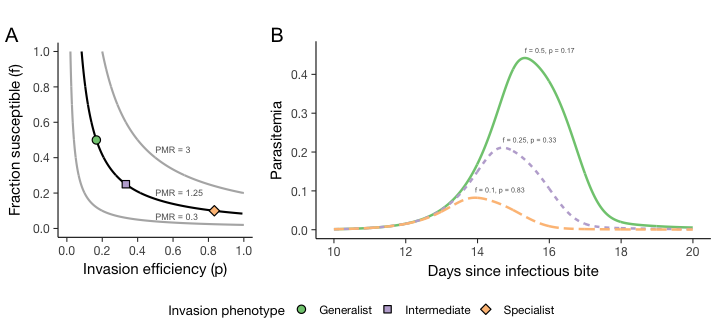

In [337]:
options(repr.plot.width = 6, repr.plot.height = 2.7)

#fig4ab.theme <- theme(legend.justification = c(0.58, 0))
# g <- grid_arrange_shared_legend(fig4a + fig4ab.theme, fig4b, position = 'bottom') %>%
#   label.grob.2(c("A", "B"), grob.height = 10)

a <- (fig5a + theme(legend.position = 'none')) %>% label.grob("A")
b <- fig5b %>% label.grob("B", y = -0.3)
g <- arrangeGrob(a, b, widths = c(2, 3.5))

a.grobs <- ggplotGrob(fig5a)$grobs
lgd <- a.grobs[[which(sapply(a.grobs, function(x) x$name) == "guide-box")]]

h <- grid.arrange(g, lgd, heights = c(10, 1))

ggsave(h, file = '../figures/paper/fig5.pdf', width = 6, height = 2.7)